In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, auc, roc_curve
from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('./Dataset/clean.csv')
df

,text,num_of_characters,num_of_words,num_of_sentences,label
0,go jurong point crazy available bugis n great ...,111,24,2,0
1,ok lar joking wif u oni,29,8,2,0
2,free entry 2 wkly comp win fa cup final tkts 2...,155,37,2,1
3,u dun say early hor u c already say,49,13,1,0
4,nah think go usf life around though,61,15,1,0
...,...,...,...,...,...
5089,2nd time tried 2 contact u pound prize 2 claim...,161,35,4,1
5090,b going esplanade fr home,37,9,1,0
5091,pity mood suggestion,57,15,2,0
5092,guy bitching acted like interested buying some...,125,27,1,0


# Define necessary functions

In [3]:
def evaluation(model, feature, label, title, metric):
    prediction = model.predict(feature)
    print(title)
    print(metric(label, prediction))

In [4]:
def visualize_confusion_matrix(model, X, y, cmap, title, ax):
    y_pred = model.predict(X)
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt="d", cmap=cmap, xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"], ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)

In [5]:
def visualize_auc_roc_curve(model, X_test, y_test, model_name, ax):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic (ROC) for {model_name}')
    ax.legend(loc='lower right')

In [6]:
def visualize_metrics_into_barchart(accuracy, test_precision, test_recall, test_f1score, auc_roc_score, model_name, ax):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    values = [accuracy, test_precision, test_recall, test_f1score, auc_roc_score]

    bar_width = 0.35
    index = np.arange(len(metrics))

    bars = ax.bar(index, values, bar_width, label='Metrics', color=['#A62527', '#F28D51', '#8EC2DC', '#313695', '#B300A6'])
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Performance Score')
    ax.set_title(f"{model_name}'s performance on the test set")
    ax.set_xticks(index)
    ax.set_xticklabels(metrics)

    for i, value in enumerate(values):
        ax.text(i, value, f'{value:.4f}', ha='center', va='bottom')

In [7]:
def roc_auc_score(model, X, y):
    y_score = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [8]:
def train_classifier(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    evaluation(model, X_train, y_train, f'Classification report of {model_name} in training set', classification_report)
    print('='*55)
    evaluation(model, X_test, y_test, f'Classification report of {model_name} in test set', classification_report)

In [9]:
def overall_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
    print(f'Precision: {round(precision_score(y_test, y_pred), 4)}')
    print(f'Recall: {round(recall_score(y_test, y_pred), 4)}')
    print(f'F1-score: {round(f1_score(y_test, y_pred), 4)}')

In [10]:
def overall_evaluation_with_threshold(model, X_test, y_test, threshold):

    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_prob > threshold).astype(int)

    print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 4)}')
    print(f'Precision: {round(precision_score(y_test, y_test_pred), 4)}')
    print(f'Recall: {round(recall_score(y_test, y_test_pred), 4)}')
    print(f'F1-score: {round(f1_score(y_test, y_test_pred), 4)}')

In [11]:
def visualize_confusion_matrix_threshold(model, X, y, cmap, title, ax, threshold):
    
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob > threshold).astype(int)

    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt="d", cmap=cmap, xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"], ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)

# 1. With only 'text' feature

In [12]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [13]:
# Data vectorizer
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
X_test = tfidf.transform(X_test)

# 2. Modeling

## 2.1. Logistic Regression

### 2.1.1. Default hyperparameters

In [14]:
log_reg = LogisticRegression()
train_classifier(log_reg, 'LR', X_train, y_train, X_test, y_test)

Classification report of LR in training set
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2861
           1       0.99      0.66      0.79       399

    accuracy                           0.96      3260
   macro avg       0.97      0.83      0.88      3260
weighted avg       0.96      0.96      0.95      3260

Classification report of LR in test set
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       894
           1       0.99      0.56      0.71       125

    accuracy                           0.95      1019
   macro avg       0.96      0.78      0.84      1019
weighted avg       0.95      0.95      0.94      1019



In [15]:
overall_evaluation(log_reg, X_test, y_test)

Accuracy: 0.945
Precision: 0.9859
Recall: 0.56
F1-score: 0.7143


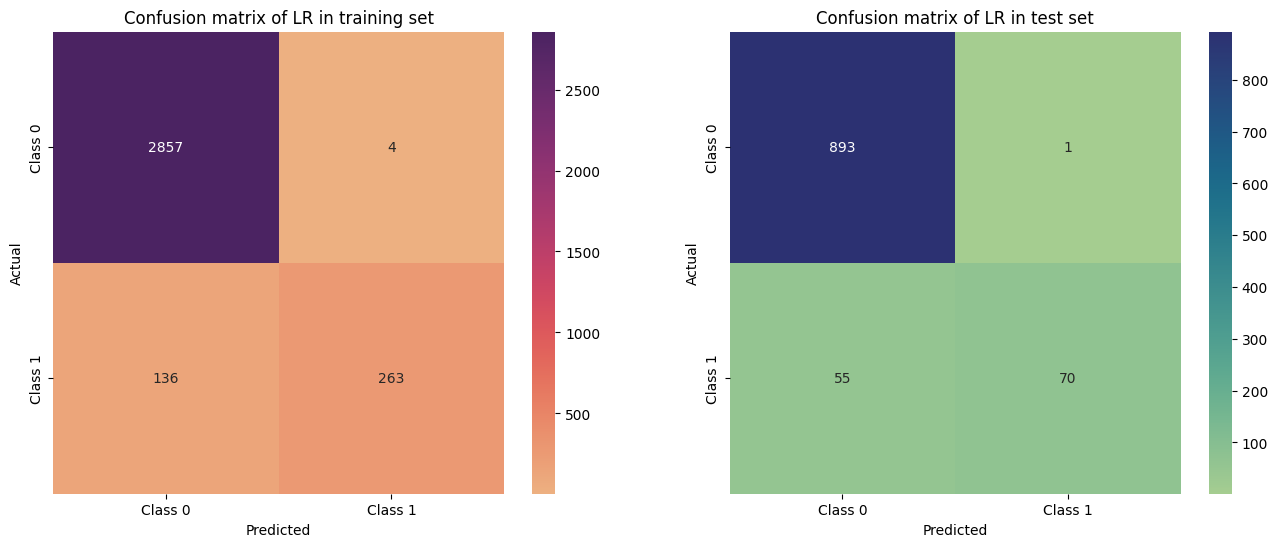

In [209]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=log_reg, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=log_reg, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

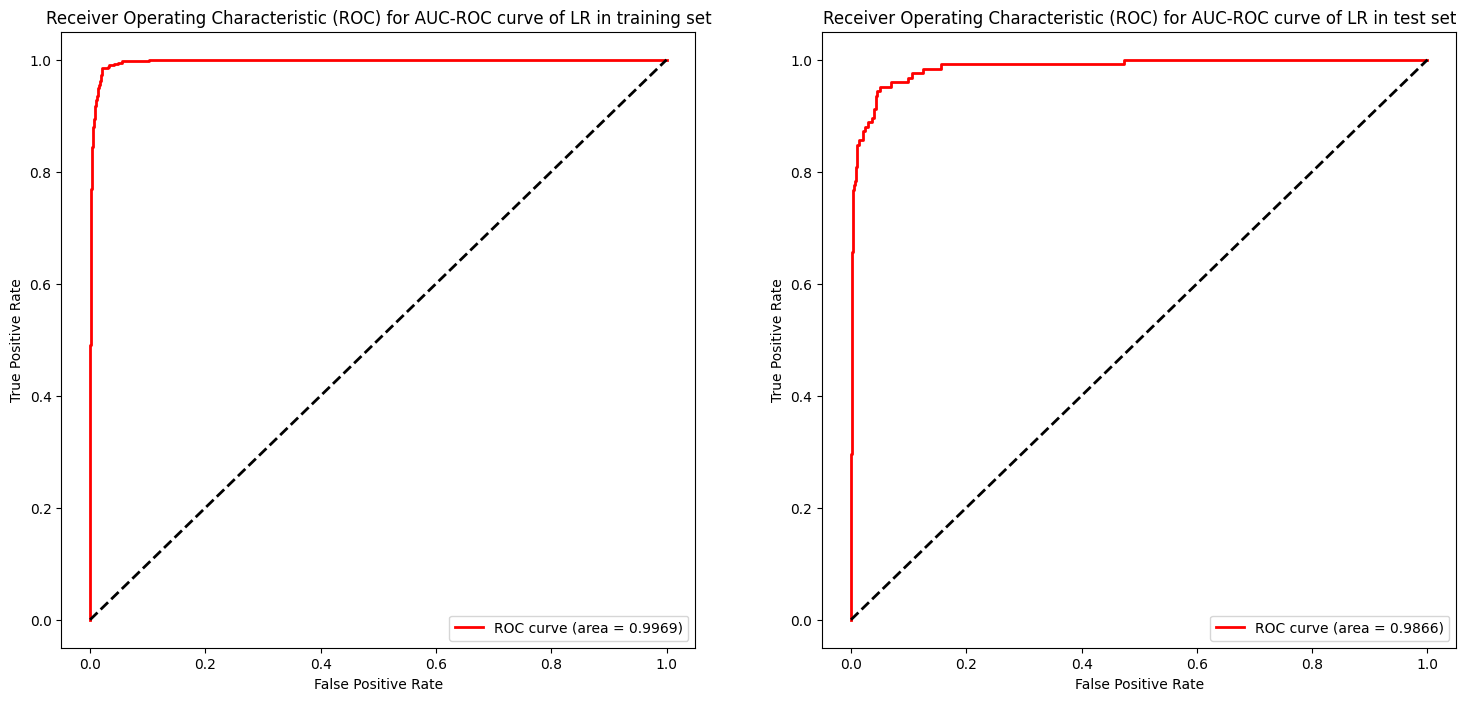

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=log_reg, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=log_reg, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

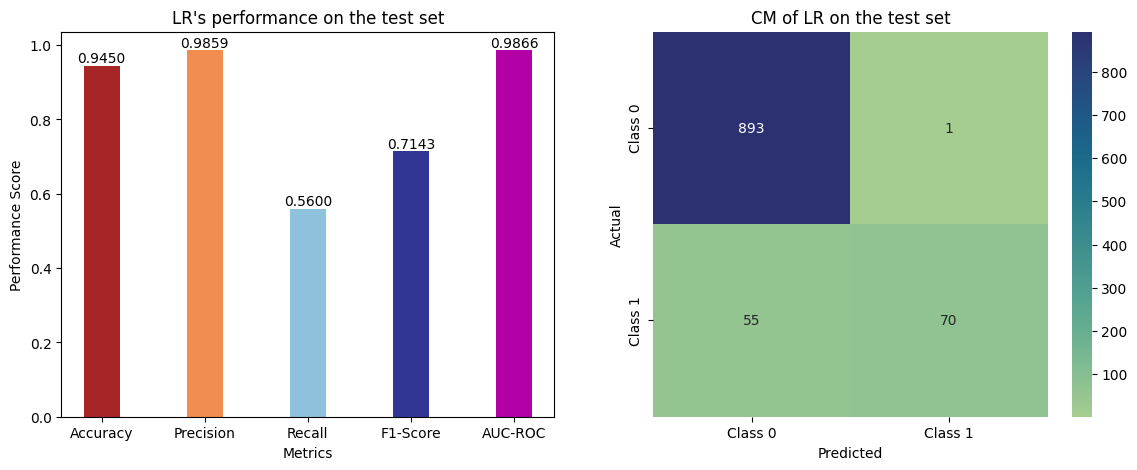

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, log_reg.predict(X_test)),
                                precision_score(y_test, log_reg.predict(X_test)),
                                recall_score(y_test, log_reg.predict(X_test)),
                                f1_score(y_test, log_reg.predict(X_test)),
                                roc_auc_score(log_reg, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix(model=log_reg, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1])

### 2.1.2. Hyperparameters tuning

In [54]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'max_iter': [10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=15, scoring='f1')
grid_search.fit(X_val, y_val)
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
# 'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 10, 'penalty': 'l2', 'solver': 'newton-cg'

c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Best hyperparameters: {'C': 1000, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
21000 fits failed out of a total of 37800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    

In [18]:
# scoring='recall':
#   - cv=[5, 10, 15]:
#        C=0.001, class_weight='balanced', fit_intercept=True, max_iter=1, penalty='l2', solver='liblinear'
# scoring='f1':
#   - cv=5:
#        C=10, class_weight='balanced', fit_intercept=True, max_iter=10, penalty='l2', solver='newton-cg'
#   - cv=10:
#        C=100, class_weight='balanced', fit_intercept=True, max_iter=10, penalty='l2', solver='liblinear'
#   - cv=15:
#        C=1000, class_weight='balanced', fit_intercept=True, max_iter=10, penalty='l2', solver='newton-cg'

log_reg_2 = LogisticRegression(C=1000, class_weight='balanced', fit_intercept=True, max_iter=10, penalty='l2', solver='newton-cg')
train_classifier(log_reg_2, 'LR', X_train, y_train, X_test, y_test)

Classification report of LR in training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2861
           1       1.00      1.00      1.00       399

    accuracy                           1.00      3260
   macro avg       1.00      1.00      1.00      3260
weighted avg       1.00      1.00      1.00      3260

Classification report of LR in test set
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       894
           1       0.97      0.86      0.92       125

    accuracy                           0.98      1019
   macro avg       0.98      0.93      0.95      1019
weighted avg       0.98      0.98      0.98      1019



c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [19]:
overall_evaluation(log_reg_2, X_test, y_test)

Accuracy: 0.9804
Precision: 0.973
Recall: 0.864
F1-score: 0.9153


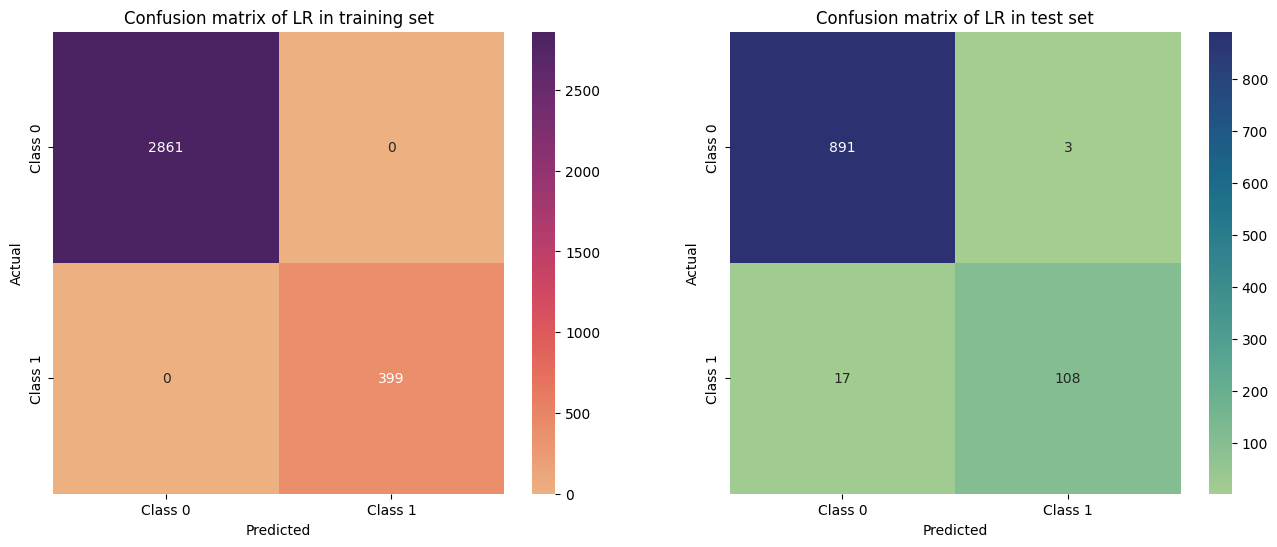

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=log_reg_2, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=log_reg_2, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

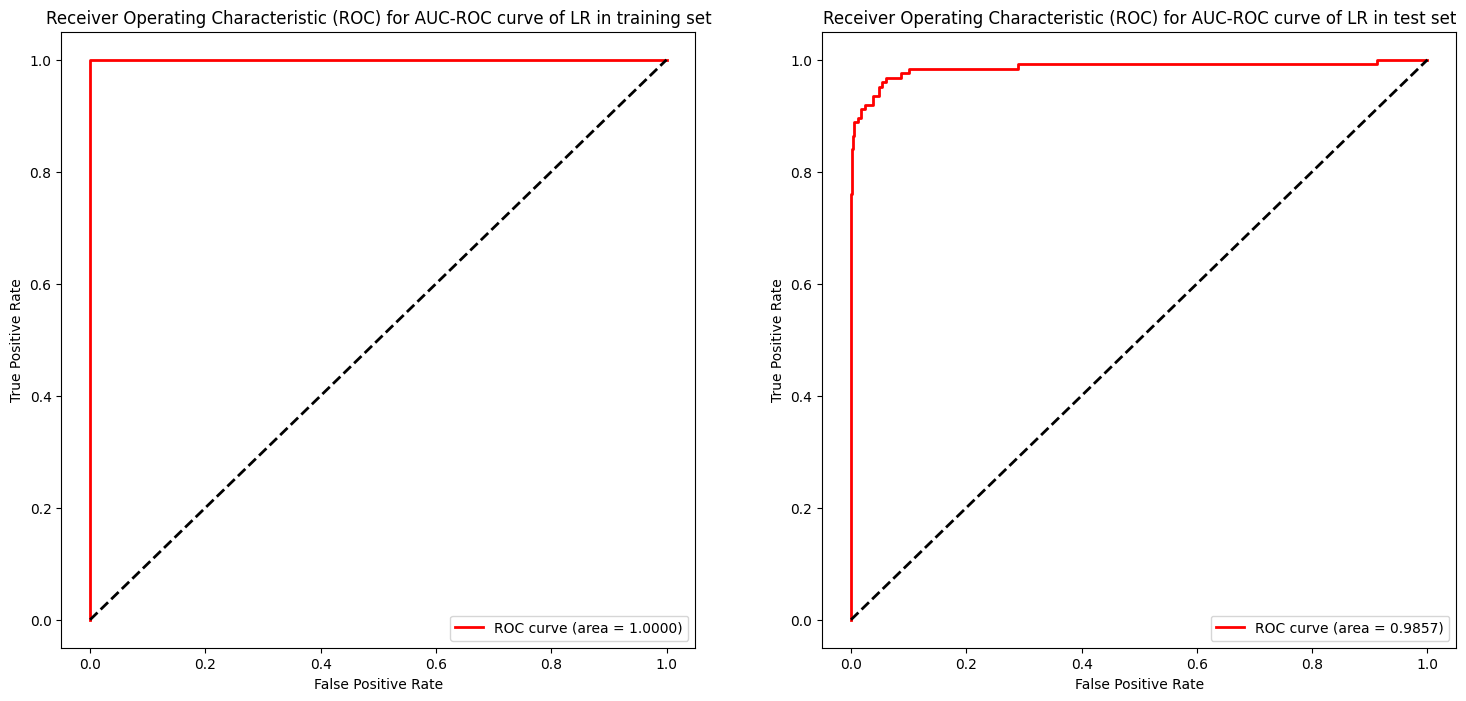

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=log_reg_2, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=log_reg_2, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

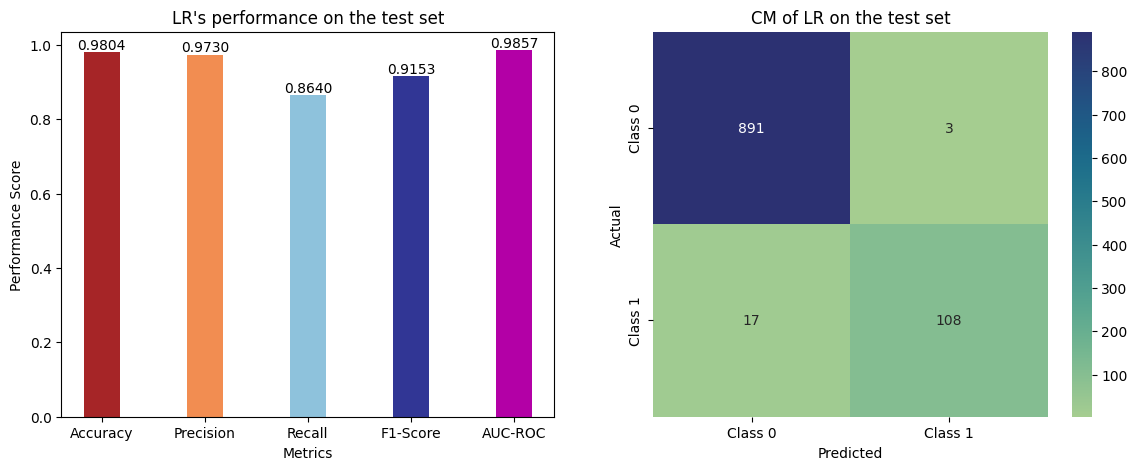

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, log_reg_2.predict(X_test)),
                                precision_score(y_test, log_reg_2.predict(X_test)),
                                recall_score(y_test, log_reg_2.predict(X_test)),
                                f1_score(y_test, log_reg_2.predict(X_test)),
                                roc_auc_score(log_reg_2, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix(model=log_reg_2, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1])

### 2.1.3. Threshold tuning

In [48]:
log_reg_3 = LogisticRegression(class_weight='balanced')

log_reg_3.fit(X_train, y_train)

y_prob = log_reg_3.predict_proba(X_val)[:, 1]

# Threshold tuning
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    
    print(f"Threshold: {threshold}, F1: {f1}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")

y_train_prob = log_reg_3.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_prob > best_threshold).astype(int)
print("Classification report on training set:")
print(classification_report(y_train, y_train_pred))


y_test_prob = log_reg_3.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob > best_threshold).astype(int)
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Threshold: 0.2, F1: 0.5756676557863503
Threshold: 0.3, F1: 0.7692307692307693
Threshold: 0.4, F1: 0.8468468468468469
Threshold: 0.5, F1: 0.862559241706161
Threshold: 0.6, F1: 0.89
Threshold: 0.7, F1: 0.8631578947368421
Threshold: 0.8, F1: 0.8114285714285713
Threshold: 0.9, F1: 0.553191489361702
Best Threshold: 0.6, Best F1-Score: 0.89
Classification report on training set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2861
           1       0.95      0.95      0.95       399

    accuracy                           0.99      3260
   macro avg       0.97      0.97      0.97      3260
weighted avg       0.99      0.99      0.99      3260

Classification report on test set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       894
           1       0.92      0.83      0.87       125

    accuracy                           0.97      1019
   macro avg       0.95      0.91      0.93 

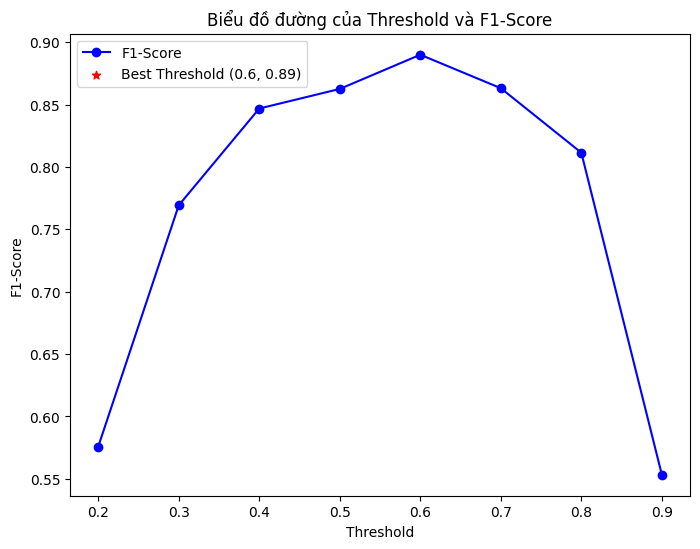

In [24]:
# Dữ liệu ngưỡng và F1-score
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
f1_scores = [0.5756676557863503, 0.7692307692307693, 0.8468468468468469, 0.862559241706161, 
              0.89, 0.8631578947368421, 0.8114285714285713, 0.553191489361702]

# Biểu đồ đường
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o', linestyle='-', color='b', label='F1-Score')
plt.scatter([0.6], [0.89], color='r', marker='*', label='Best Threshold (0.6, 0.89)')

# Đặt tên cho trục và biểu đồ
plt.title('Biểu đồ đường của Threshold và F1-Score')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.legend()

In [25]:
overall_evaluation_with_threshold(log_reg_3, X_test, y_test, threshold=0.6)

Accuracy: 0.9706
Precision: 0.9204
Recall: 0.832
F1-score: 0.8739


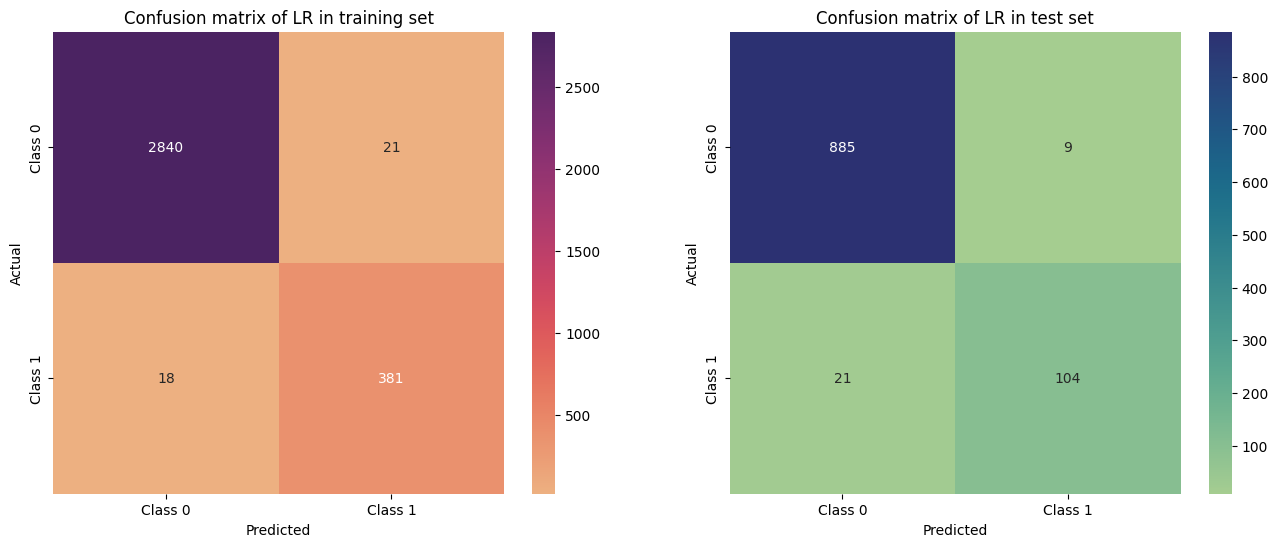

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix_threshold(model=log_reg_3, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0], threshold=0.6)
visualize_confusion_matrix_threshold(model=log_reg_3, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1], threshold=0.6)

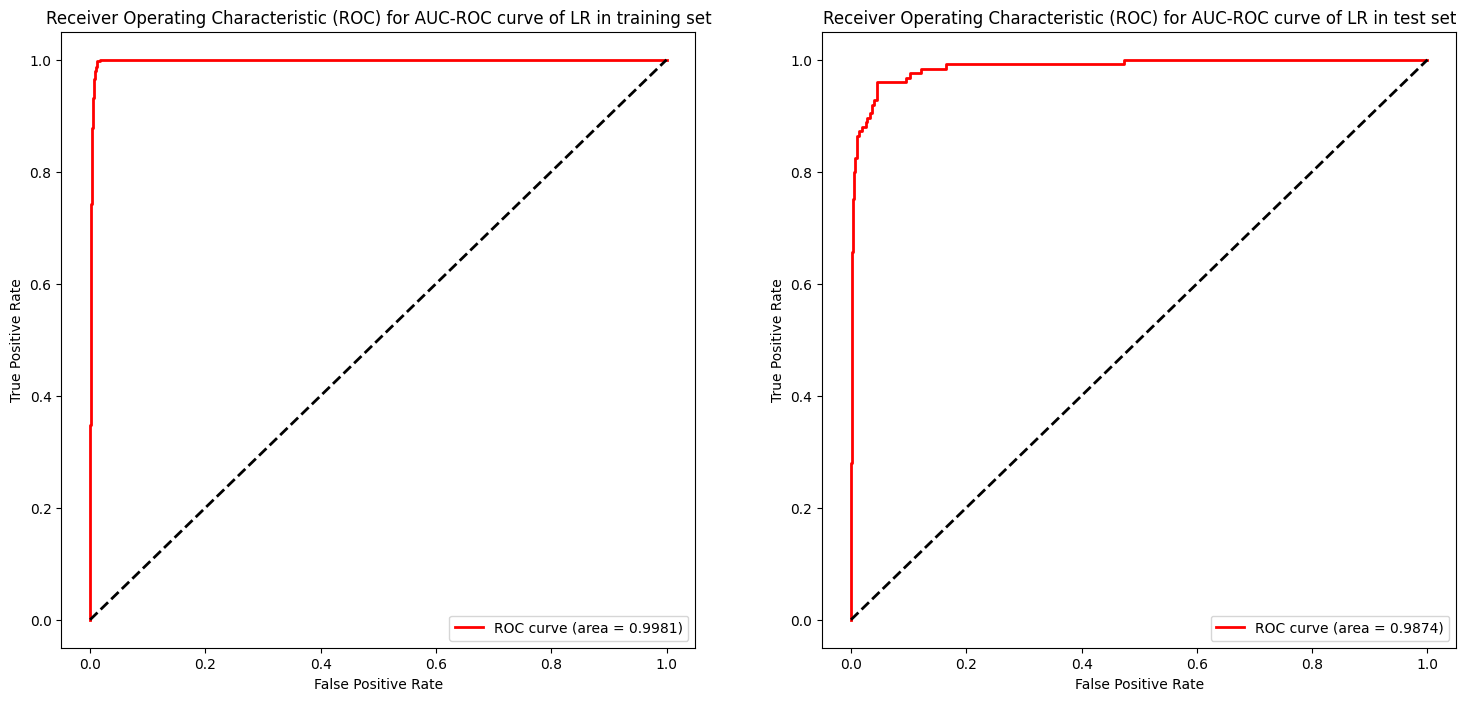

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=log_reg_3, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=log_reg_3, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

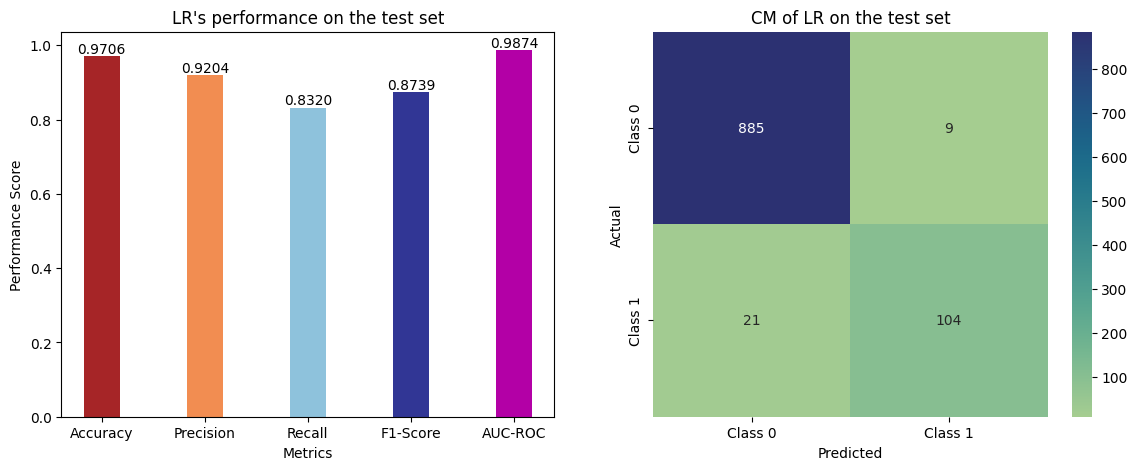

In [28]:
y_test_prob = log_reg_3.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob > 0.6).astype(int)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, y_test_pred),
                                precision_score(y_test, y_test_pred),
                                recall_score(y_test, y_test_pred),
                                f1_score(y_test, y_test_pred),
                                roc_auc_score(log_reg_3, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix_threshold(model=log_reg_3, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1], threshold=0.6)

### 2.1.4. Cross validation

In [29]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a logistic regression model
log_reg_4 = LogisticRegression(class_weight='balanced')

X_train_arr = X_train.toarray()

# Variables to store overall performance metrics
total_accuracy_train = 0
total_accuracy_test = 0

# Metrics history
fold_numbers = list(range(1, 11))
training_accuracy_history = []
test_accuracy_history = []
training_precision_history = []
test_precision_history = []
training_recall_history = []
test_recall_history = []
training_f1score_history = []
test_f1score_history = []
i = 0

# Perform KFold cross-validation
for train_index, test_index in skf.split(X_train_arr, y_train):
    X_train_f, X_test_f = X_train_arr[train_index], X_train_arr[test_index]
    y_train_f, y_test_f = y_train.iloc[train_index], y_train.iloc[test_index]  # Sử dụng iloc để lấy dữ liệu từ DataFrame

    # Train the model
    log_reg_4.fit(X_train_f, y_train_f)

    # Make predictions
    y_train_pred = log_reg_4.predict(X_train_f)
    y_test_pred = log_reg_4.predict(X_test_f)

    # Log all values for model evaluation
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    precision_train = precision_score(y_train_f, y_train_pred)
    precision_test = precision_score(y_test_f, y_test_pred)
    recall_train = recall_score(y_train_f, y_train_pred)
    recall_test = recall_score(y_test_f, y_test_pred)
    f1_train = f1_score(y_train_f, y_train_pred)
    f1_test = f1_score(y_test_f, y_test_pred)

    # Append values to the history lists
    training_accuracy_history.append(accuracy_train)
    test_accuracy_history.append(accuracy_test)
    training_precision_history.append(precision_train)
    test_precision_history.append(precision_test)
    training_recall_history.append(recall_train)
    test_recall_history.append(recall_test)
    training_f1score_history.append(f1_train)
    test_f1score_history.append(f1_test)

    # Evaluate the model
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    total_accuracy_train += accuracy_train
    total_accuracy_test += accuracy_test

    # Print classification report and confusion matrix for each fold
    print(f'\nFold {i + 1}:')
    print(f'Accuracy (Train): {accuracy_train}')
    print('Classification Report (Train):')
    print(classification_report(y_train_f, y_train_pred))

    print('Confusion Matrix (Train):')
    print(confusion_matrix(y_train_f, y_train_pred))

    print(f'Accuracy (Test): {accuracy_test}')
    print('Classification Report (Test):')
    print(classification_report(y_test_f, y_test_pred))

    print('Confusion Matrix (Test):')
    print(confusion_matrix(y_test_f, y_test_pred))

    i+=1

# Calculate the average accuracy over all folds
average_accuracy_train = total_accuracy_train / n_splits
average_accuracy_test = total_accuracy_test / n_splits

print(f'Average Training Accuracy: {average_accuracy_train}')
print(f'Average Testing Accuracy: {average_accuracy_test}')


Fold 1:
Accuracy (Train): 0.9870483980913429
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2574
           1       0.91      0.99      0.95       360

    accuracy                           0.99      2934
   macro avg       0.95      0.99      0.97      2934
weighted avg       0.99      0.99      0.99      2934

Confusion Matrix (Train):
[[2538   36]
 [   2  358]]
Accuracy (Test): 0.9662576687116564
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       287
           1       0.89      0.82      0.85        39

    accuracy                           0.97       326
   macro avg       0.93      0.90      0.92       326
weighted avg       0.97      0.97      0.97       326

Confusion Matrix (Test):
[[283   4]
 [  7  32]]

Fold 2:
Accuracy (Train): 0.9887525562372188
Classification Report (Train):
              precision  

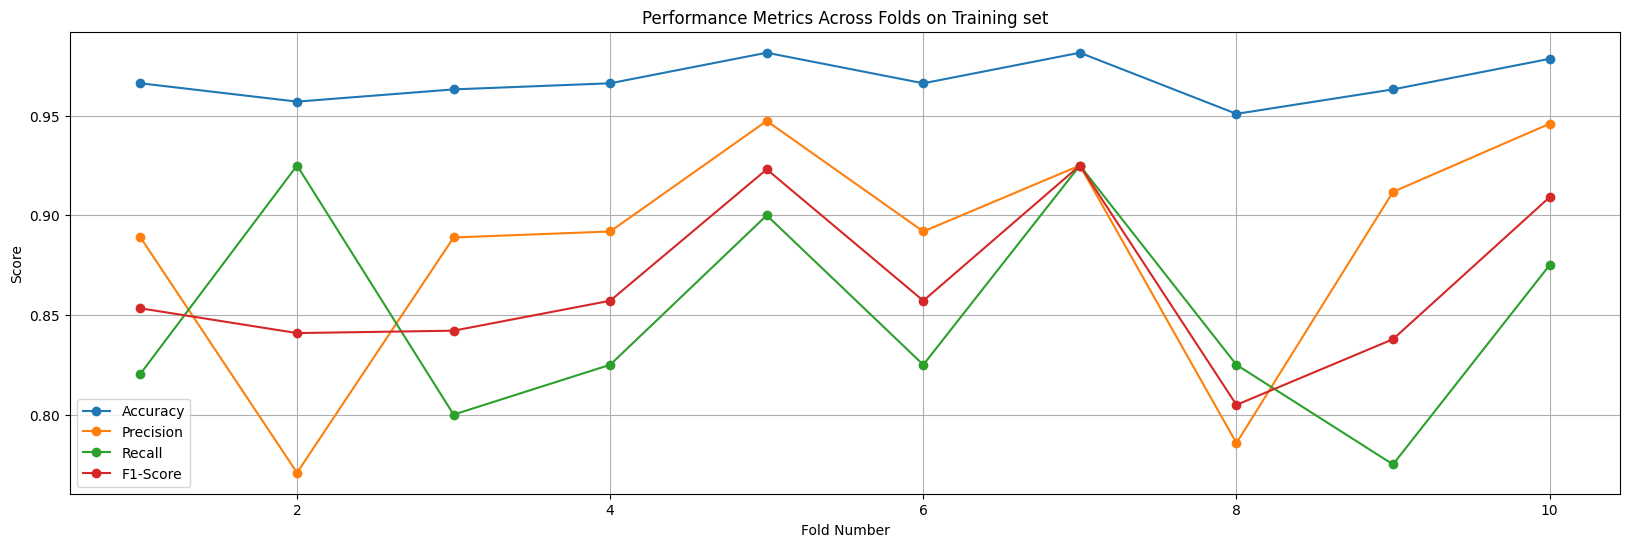

In [31]:
# Trực quan hóa dữ liệu
plt.figure(figsize=(20, 6))

plt.plot(fold_numbers, test_accuracy_history, label='Accuracy', marker='o')
plt.plot(fold_numbers, test_precision_history, label='Precision', marker='o')
plt.plot(fold_numbers, test_recall_history, label='Recall', marker='o')
plt.plot(fold_numbers, test_f1score_history, label='F1-Score', marker='o')

plt.title('Performance Metrics Across Folds on Training set')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Hiển thị giá trị cụ thể tại các điểm trên đồ thị
# for i, (acc, prec, rec, f1) in enumerate(zip(test_accuracy_history, test_precision_history, test_recall_history, test_f1score_history)):
#     plt.annotate(f'Fold {i+1}\nAcc: {acc:.2f}\nPrec: {prec:.2f}\nRec: {rec:.2f}\nF1: {f1:.2f}', 
#                  xy=(fold_numbers[i], acc), 
#                  xytext=(5, -10), 
#                  textcoords='offset points',
#                  ha='center')

plt.show()

In [32]:
evaluation(log_reg_4, X_train, y_train, 'Classification report on training set:', metric=classification_report)
print()
evaluation(log_reg_4, X_test, y_test, 'Classification report on test set:', metric=classification_report)

Classification report on training set:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2861
           1       0.92      0.98      0.95       399

    accuracy                           0.99      3260
   macro avg       0.96      0.99      0.97      3260
weighted avg       0.99      0.99      0.99      3260


Classification report on test set:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       894
           1       0.88      0.87      0.88       125

    accuracy                           0.97      1019
   macro avg       0.93      0.93      0.93      1019
weighted avg       0.97      0.97      0.97      1019



In [33]:
overall_evaluation(log_reg_4, X_test, y_test)

Accuracy: 0.9696
Precision: 0.879
Recall: 0.872
F1-score: 0.8755


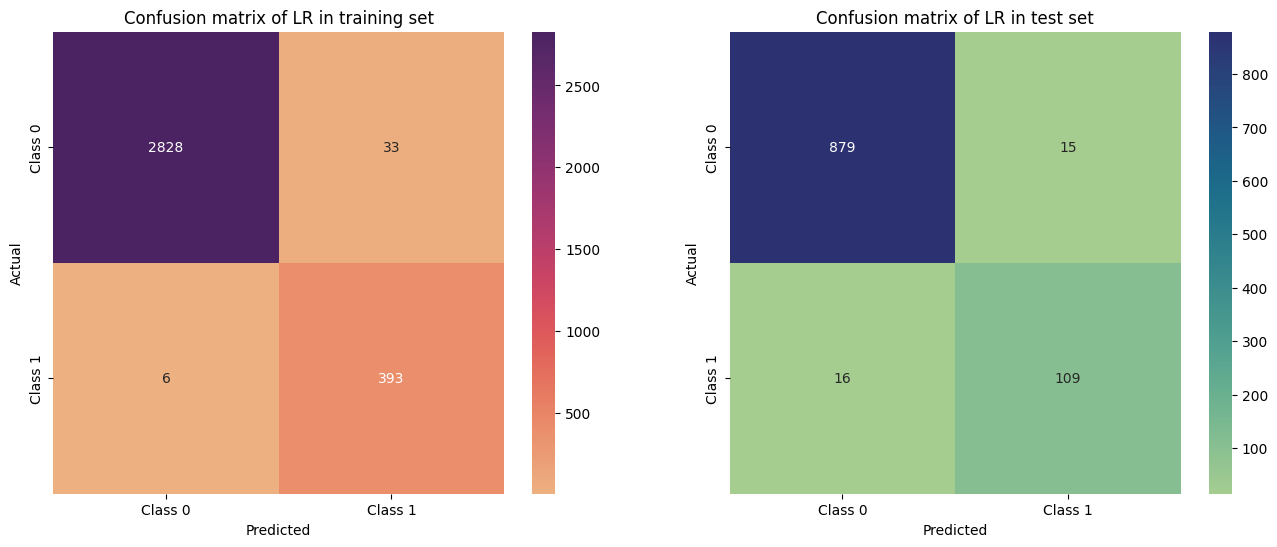

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=log_reg_4, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=log_reg_4, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

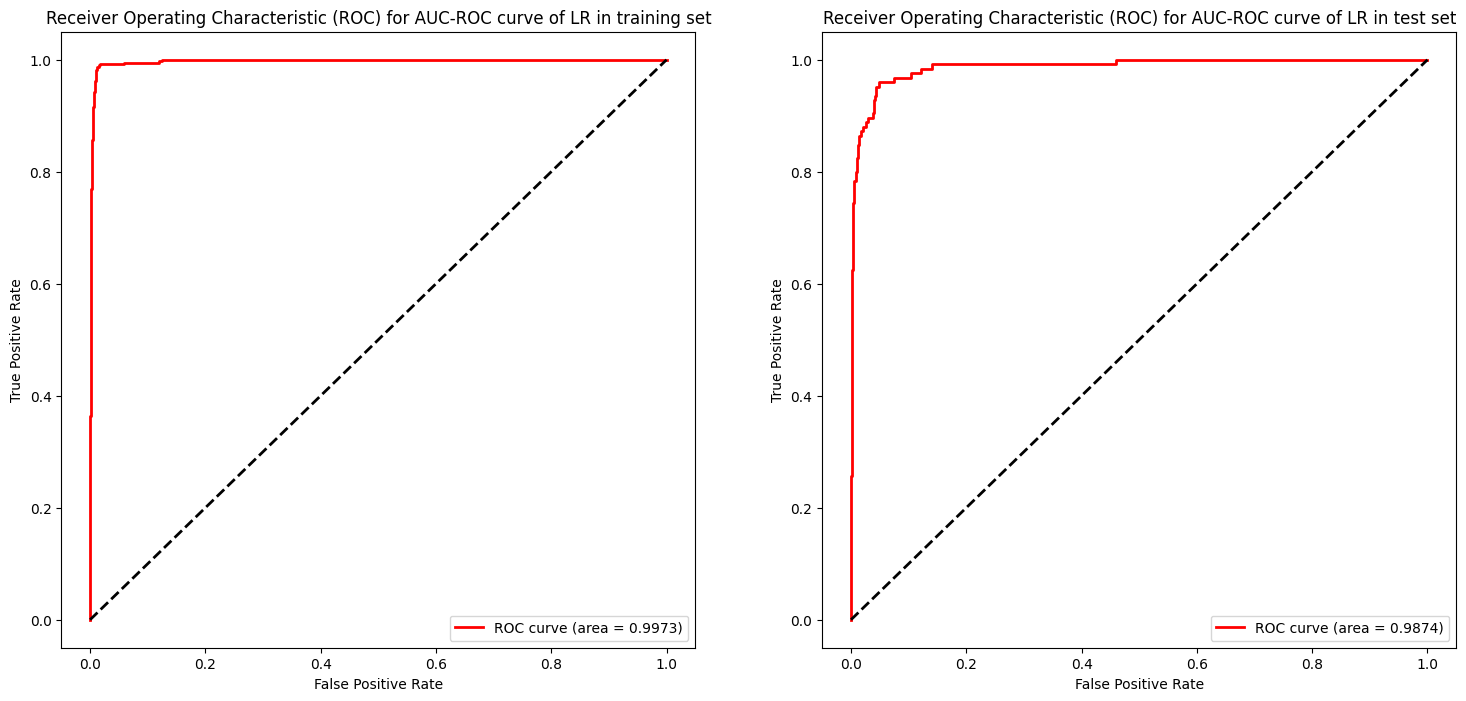

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=log_reg_4, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=log_reg_4, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

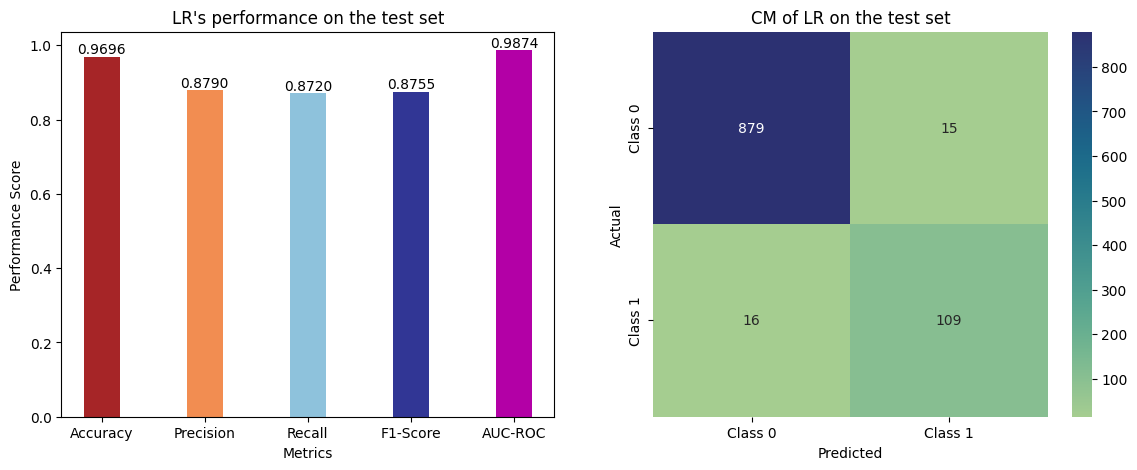

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, log_reg_4.predict(X_test)),
                                precision_score(y_test, log_reg_4.predict(X_test)),
                                recall_score(y_test, log_reg_4.predict(X_test)),
                                f1_score(y_test, log_reg_4.predict(X_test)),
                                roc_auc_score(log_reg_4, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix(model=log_reg_4, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1])

### 2.1.5. Hyperparameters tuning with threshold tuning

In [49]:
y_prob = log_reg_2.predict_proba(X_val)[:, 1]

# Threshold tuning
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    
    print(f"Threshold: {threshold}, F1: {f1}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")

y_train_prob = log_reg_2.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_prob > best_threshold).astype(int)
print("Classification report on training set:")
print(classification_report(y_train, y_train_pred))


y_test_prob = log_reg_2.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob > best_threshold).astype(int)
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Threshold: 0.2, F1: 0.896551724137931
Threshold: 0.3, F1: 0.9054726368159204
Threshold: 0.4, F1: 0.888888888888889
Threshold: 0.5, F1: 0.8934010152284264
Threshold: 0.6, F1: 0.8979591836734694
Threshold: 0.7, F1: 0.9005235602094239
Threshold: 0.8, F1: 0.9005235602094239
Threshold: 0.9, F1: 0.9042553191489362
Best Threshold: 0.3, Best F1-Score: 0.9054726368159204
Classification report on training set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2861
           1       1.00      1.00      1.00       399

    accuracy                           1.00      3260
   macro avg       1.00      1.00      1.00      3260
weighted avg       1.00      1.00      1.00      3260

Classification report on test set:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       894
           1       0.97      0.89      0.92       125

    accuracy                           0.98      1019
   macro avg    

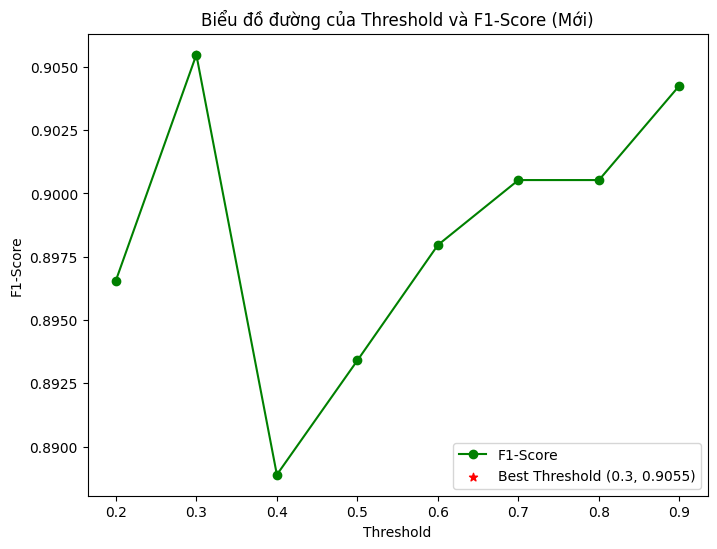

In [42]:
thresholds_new = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
f1_scores_new = [0.896551724137931, 0.9054726368159204, 0.888888888888889, 0.8934010152284264,
                 0.8979591836734694, 0.9005235602094239, 0.9005235602094239, 0.9042553191489362]

# Biểu đồ đường
plt.figure(figsize=(8, 6))
plt.plot(thresholds_new, f1_scores_new, marker='o', linestyle='-', color='g', label='F1-Score')
plt.scatter([0.3], [0.9054726368159204], color='r', marker='*', label='Best Threshold (0.3, 0.9055)')

# Đặt tên cho trục và biểu đồ
plt.title('Biểu đồ đường của Threshold và F1-Score (Mới)')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.legend()

In [38]:
overall_evaluation_with_threshold(log_reg_2, X_test, y_test, threshold=0.6)

Accuracy: 0.9794
Precision: 0.9727
Recall: 0.856
F1-score: 0.9106


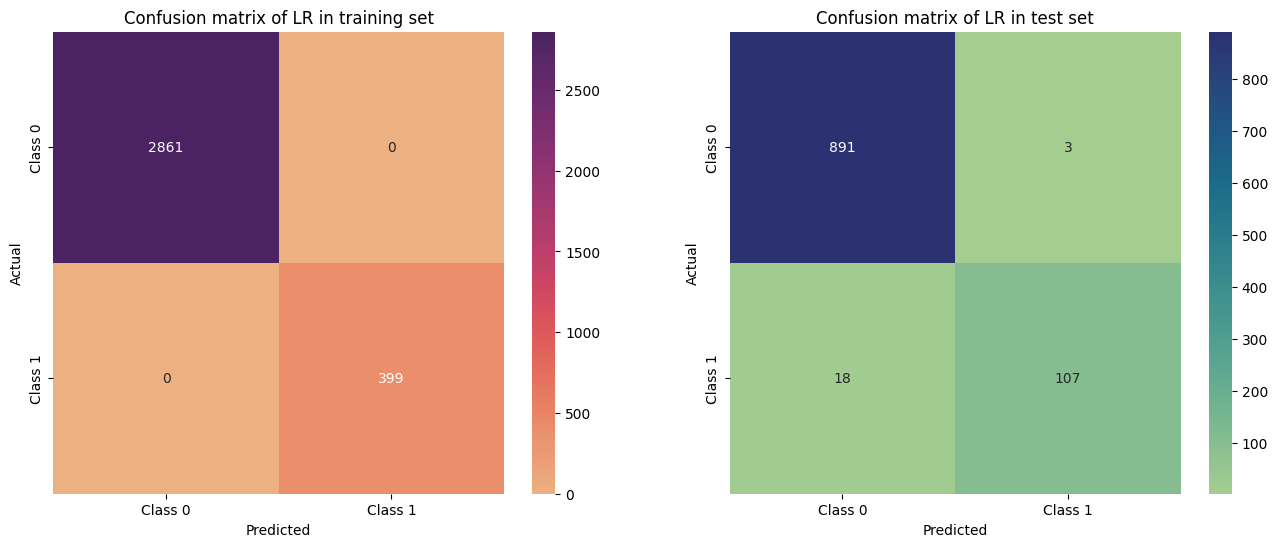

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix_threshold(model=log_reg_2, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0], threshold=0.6)
visualize_confusion_matrix_threshold(model=log_reg_2, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1], threshold=0.6)

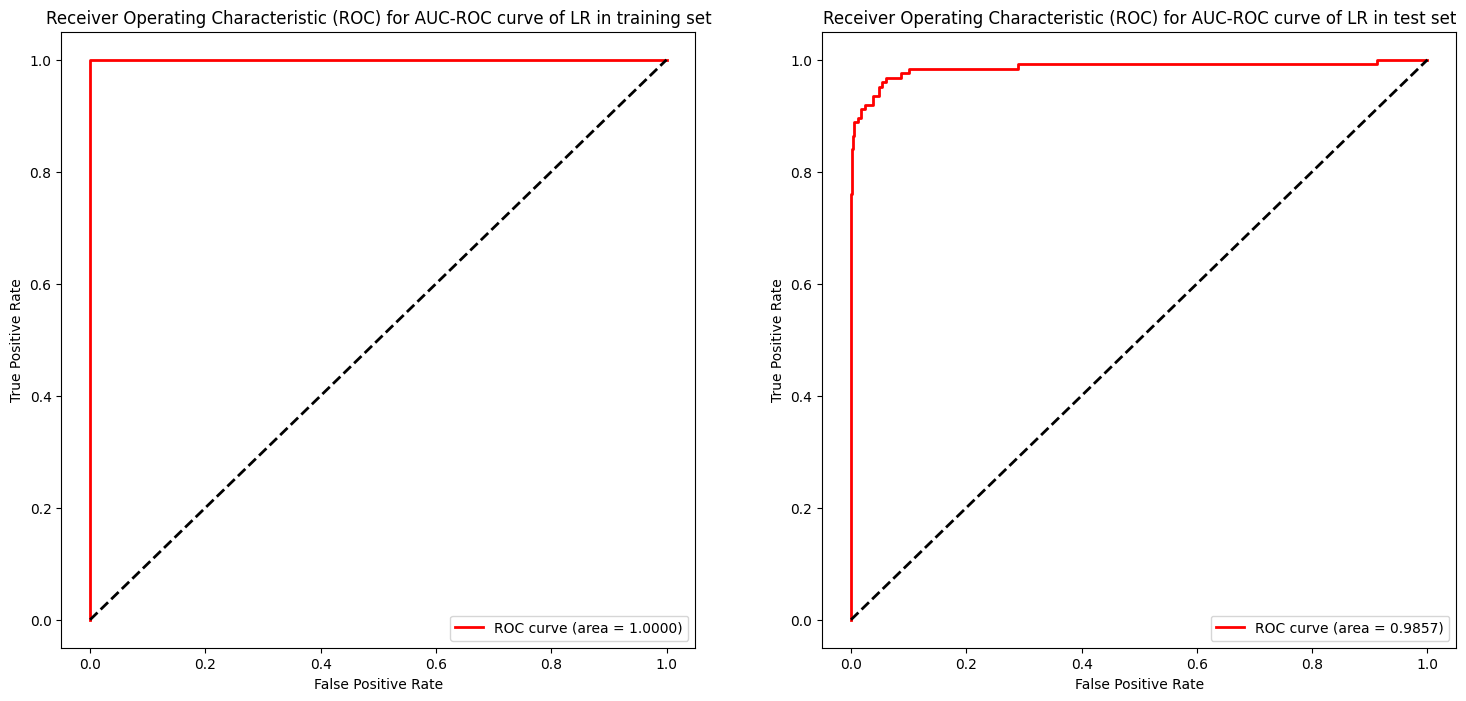

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=log_reg_2, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=log_reg_2, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

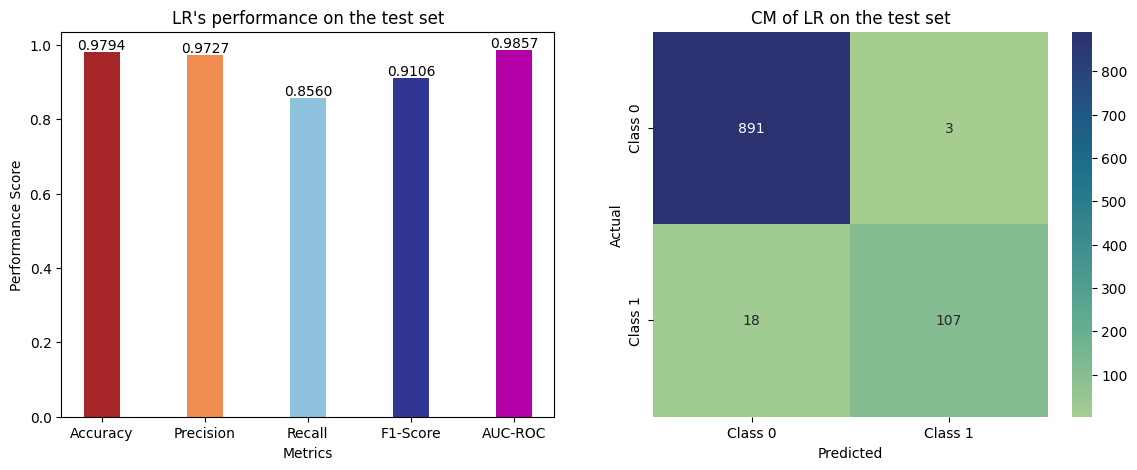

In [41]:
y_test_prob = log_reg_2.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob > 0.6).astype(int)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, y_test_pred),
                                precision_score(y_test, y_test_pred),
                                recall_score(y_test, y_test_pred),
                                f1_score(y_test, y_test_pred),
                                roc_auc_score(log_reg_2, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix_threshold(model=log_reg_2, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1], threshold=0.6)

### 2.1.6. Cross validation with hyperparameters tuning

In [43]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a logistic regression model
log_reg_5 = LogisticRegression(C=1000, class_weight='balanced', fit_intercept=True, max_iter=10, penalty='l2', solver='newton-cg')

X_train_arr = X_train.toarray()

# Variables to store overall performance metrics
total_accuracy_train = 0
total_accuracy_test = 0

# Metrics history
fold_numbers = list(range(1, 11))
training_accuracy_history = []
test_accuracy_history = []
training_precision_history = []
test_precision_history = []
training_recall_history = []
test_recall_history = []
training_f1score_history = []
test_f1score_history = []
i = 0

# Perform KFold cross-validation
for train_index, test_index in skf.split(X_train_arr, y_train):
    X_train_f, X_test_f = X_train_arr[train_index], X_train_arr[test_index]
    y_train_f, y_test_f = y_train.iloc[train_index], y_train.iloc[test_index]  # Sử dụng iloc để lấy dữ liệu từ DataFrame

    # Train the model
    log_reg_5.fit(X_train_f, y_train_f)

    # Make predictions
    y_train_pred = log_reg_5.predict(X_train_f)
    y_test_pred = log_reg_5.predict(X_test_f)

    # Log all values for model evaluation
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    precision_train = precision_score(y_train_f, y_train_pred)
    precision_test = precision_score(y_test_f, y_test_pred)
    recall_train = recall_score(y_train_f, y_train_pred)
    recall_test = recall_score(y_test_f, y_test_pred)
    f1_train = f1_score(y_train_f, y_train_pred)
    f1_test = f1_score(y_test_f, y_test_pred)

    # Append values to the history lists
    training_accuracy_history.append(accuracy_train)
    test_accuracy_history.append(accuracy_test)
    training_precision_history.append(precision_train)
    test_precision_history.append(precision_test)
    training_recall_history.append(recall_train)
    test_recall_history.append(recall_test)
    training_f1score_history.append(f1_train)
    test_f1score_history.append(f1_test)

    # Evaluate the model
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    total_accuracy_train += accuracy_train
    total_accuracy_test += accuracy_test

    # Print classification report and confusion matrix for each fold
    print(f'\nFold {i + 1}:')
    print(f'Accuracy (Train): {accuracy_train}')
    print('Classification Report (Train):')
    print(classification_report(y_train_f, y_train_pred))

    print('Confusion Matrix (Train):')
    print(confusion_matrix(y_train_f, y_train_pred))

    print(f'Accuracy (Test): {accuracy_test}')
    print('Classification Report (Test):')
    print(classification_report(y_test_f, y_test_pred))

    print('Confusion Matrix (Test):')
    print(confusion_matrix(y_test_f, y_test_pred))

    i+=1

# Calculate the average accuracy over all folds
average_accuracy_train = total_accuracy_train / n_splits
average_accuracy_test = total_accuracy_test / n_splits

print(f'Average Training Accuracy: {average_accuracy_train}')
print(f'Average Testing Accuracy: {average_accuracy_test}')

c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



Fold 1:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2574
           1       1.00      1.00      1.00       360

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2574    0]
 [   0  360]]
Accuracy (Test): 0.9723926380368099
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       287
           1       0.94      0.82      0.88        39

    accuracy                           0.97       326
   macro avg       0.96      0.91      0.93       326
weighted avg       0.97      0.97      0.97       326

Confusion Matrix (Test):
[[285   2]
 [  7  32]]


c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



Fold 2:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2575
           1       1.00      1.00      1.00       359

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2575    0]
 [   0  359]]
Accuracy (Test): 0.9815950920245399
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       286
           1       0.93      0.93      0.93        40

    accuracy                           0.98       326
   macro avg       0.96      0.96      0.96       326
weighted avg       0.98      0.98      0.98       326

Confusion Matrix (Test):
[[283   3]
 [  3  37]]


c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



Fold 3:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2575
           1       1.00      1.00      1.00       359

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2575    0]
 [   0  359]]
Accuracy (Test): 0.9723926380368099
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       286
           1       0.97      0.80      0.88        40

    accuracy                           0.97       326
   macro avg       0.97      0.90      0.93       326
weighted avg       0.97      0.97      0.97       326

Confusion Matrix (Test):
[[285   1]
 [  8  32]]


c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



Fold 4:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2575
           1       1.00      1.00      1.00       359

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2575    0]
 [   0  359]]
Accuracy (Test): 0.9754601226993865
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       286
           1       0.97      0.82      0.89        40

    accuracy                           0.98       326
   macro avg       0.97      0.91      0.94       326
weighted avg       0.98      0.98      0.97       326

Confusion Matrix (Test):
[[285   1]
 [  7  33]]


c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



Fold 5:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2575
           1       1.00      1.00      1.00       359

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2575    0]
 [   0  359]]
Accuracy (Test): 0.9785276073619632
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       286
           1       1.00      0.82      0.90        40

    accuracy                           0.98       326
   macro avg       0.99      0.91      0.95       326
weighted avg       0.98      0.98      0.98       326

Confusion Matrix (Test):
[[286   0]
 [  7  33]]


c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



Fold 6:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2575
           1       1.00      1.00      1.00       359

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2575    0]
 [   0  359]]
Accuracy (Test): 0.9754601226993865
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       286
           1       1.00      0.80      0.89        40

    accuracy                           0.98       326
   macro avg       0.99      0.90      0.94       326
weighted avg       0.98      0.98      0.97       326

Confusion Matrix (Test):
[[286   0]
 [  8  32]]


c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



Fold 7:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2575
           1       1.00      1.00      1.00       359

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2575    0]
 [   0  359]]
Accuracy (Test): 0.9846625766871165
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       286
           1       0.97      0.90      0.94        40

    accuracy                           0.98       326
   macro avg       0.98      0.95      0.96       326
weighted avg       0.98      0.98      0.98       326

Confusion Matrix (Test):
[[285   1]
 [  4  36]]


c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



Fold 8:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2575
           1       1.00      1.00      1.00       359

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2575    0]
 [   0  359]]
Accuracy (Test): 0.9815950920245399
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       286
           1       1.00      0.85      0.92        40

    accuracy                           0.98       326
   macro avg       0.99      0.93      0.95       326
weighted avg       0.98      0.98      0.98       326

Confusion Matrix (Test):
[[286   0]
 [  6  34]]


c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



Fold 9:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2575
           1       1.00      1.00      1.00       359

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2575    0]
 [   0  359]]
Accuracy (Test): 0.9662576687116564
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       286
           1       0.97      0.75      0.85        40

    accuracy                           0.97       326
   macro avg       0.97      0.87      0.91       326
weighted avg       0.97      0.97      0.96       326

Confusion Matrix (Test):
[[285   1]
 [ 10  30]]

Fold 10:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support


c:\Users\ADMIN\anaconda3\envs\BasicML\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


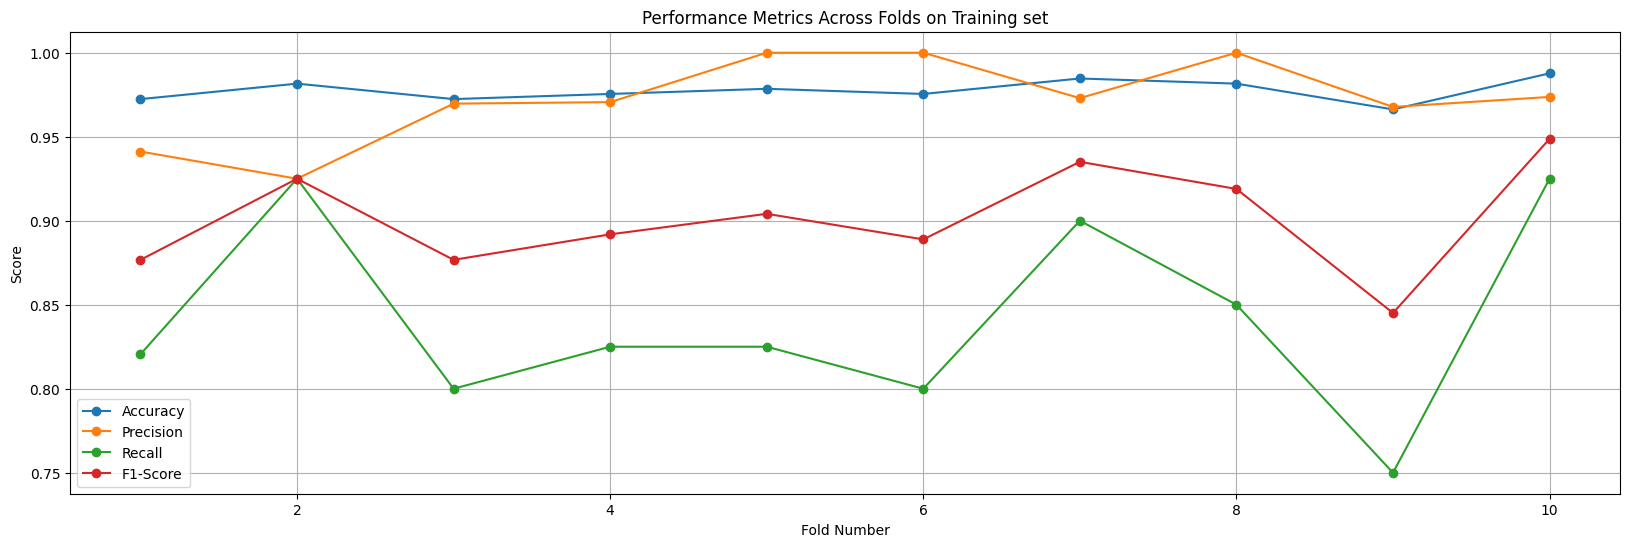

In [45]:
# Trực quan hóa dữ liệu
plt.figure(figsize=(20, 6))

plt.plot(fold_numbers, test_accuracy_history, label='Accuracy', marker='o')
plt.plot(fold_numbers, test_precision_history, label='Precision', marker='o')
plt.plot(fold_numbers, test_recall_history, label='Recall', marker='o')
plt.plot(fold_numbers, test_f1score_history, label='F1-Score', marker='o')

plt.title('Performance Metrics Across Folds on Training set')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Hiển thị giá trị cụ thể tại các điểm trên đồ thị
# for i, (acc, prec, rec, f1) in enumerate(zip(test_accuracy_history, test_precision_history, test_recall_history, test_f1score_history)):
#     plt.annotate(f'Fold {i+1}\nAcc: {acc:.2f}\nPrec: {prec:.2f}\nRec: {rec:.2f}\nF1: {f1:.2f}', 
#                  xy=(fold_numbers[i], acc), 
#                  xytext=(5, -10), 
#                  textcoords='offset points',
#                  ha='center')

plt.show()

In [46]:
evaluation(log_reg_5, X_train, y_train, 'Classification report on training set:', metric=classification_report)
print()
evaluation(log_reg_5, X_test, y_test, 'Classification report on test set:', metric=classification_report)

Classification report on training set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2861
           1       1.00      0.99      0.99       399

    accuracy                           1.00      3260
   macro avg       1.00      1.00      1.00      3260
weighted avg       1.00      1.00      1.00      3260


Classification report on test set:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       894
           1       0.96      0.85      0.90       125

    accuracy                           0.98      1019
   macro avg       0.97      0.92      0.94      1019
weighted avg       0.98      0.98      0.98      1019



In [239]:
overall_evaluation(log_reg_5, X_test, y_test)

Accuracy: 0.9774
Precision: 0.9636
Recall: 0.848
F1-score: 0.9021


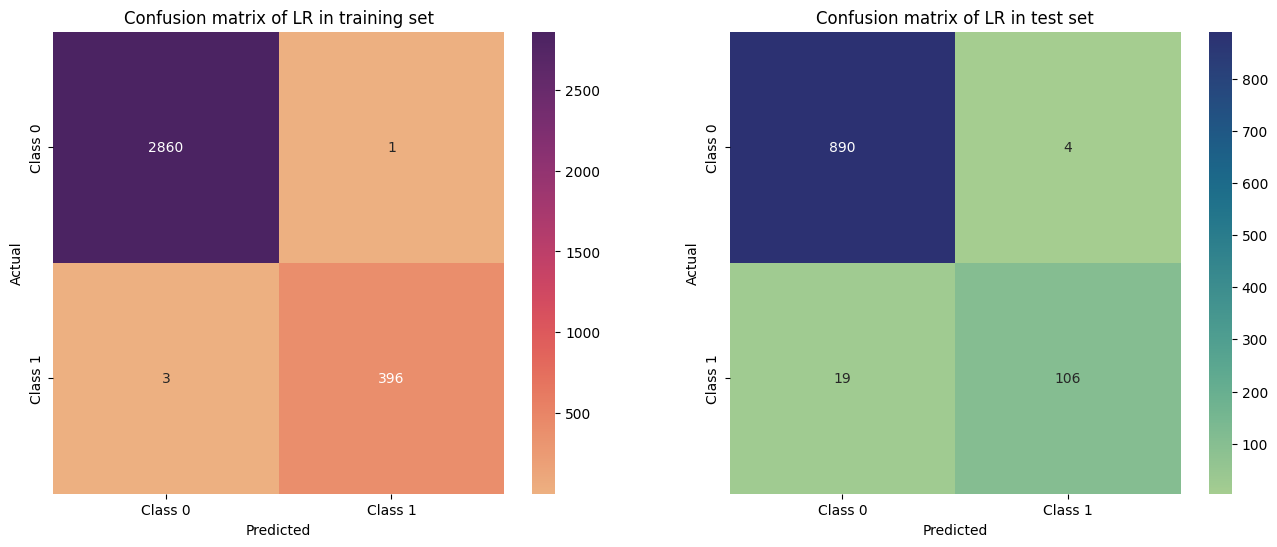

In [240]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=log_reg_5, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=log_reg_5, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

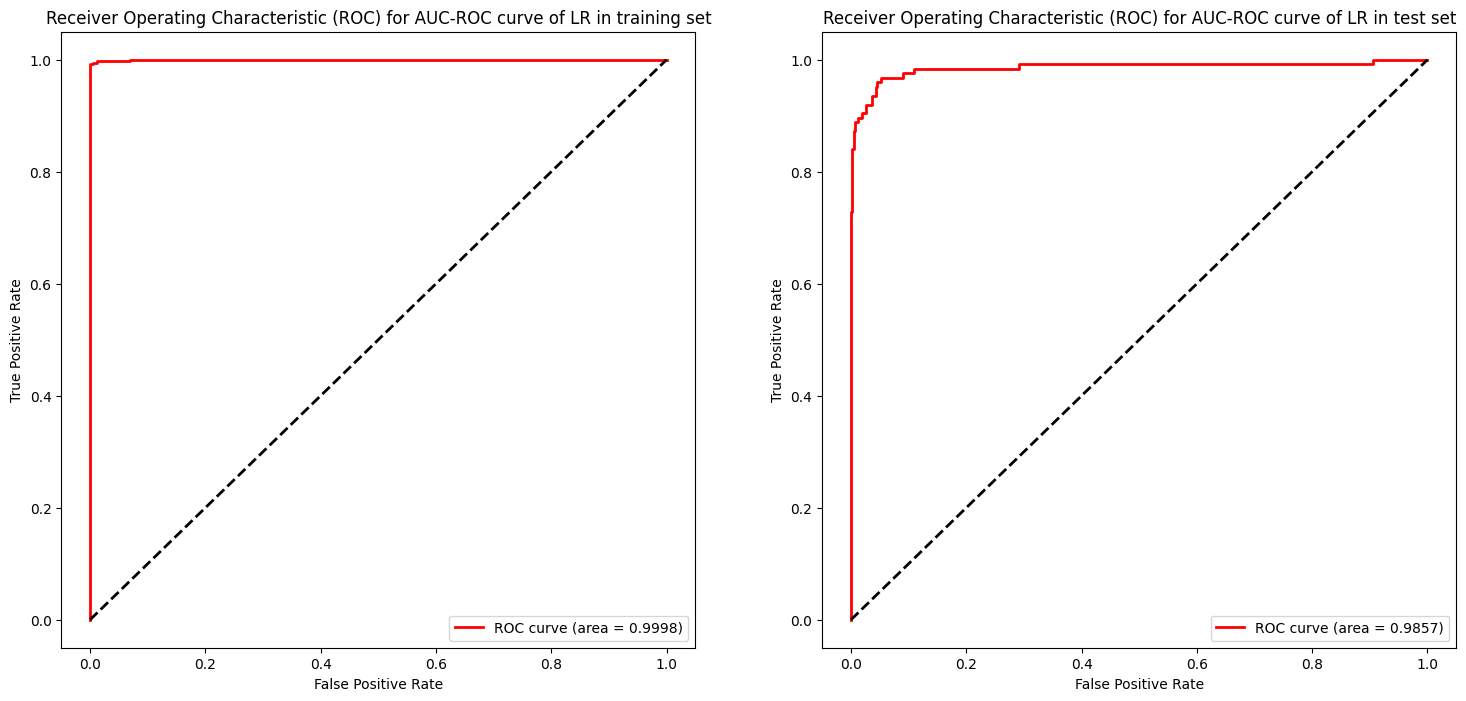

In [236]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=log_reg_5, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=log_reg_5, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

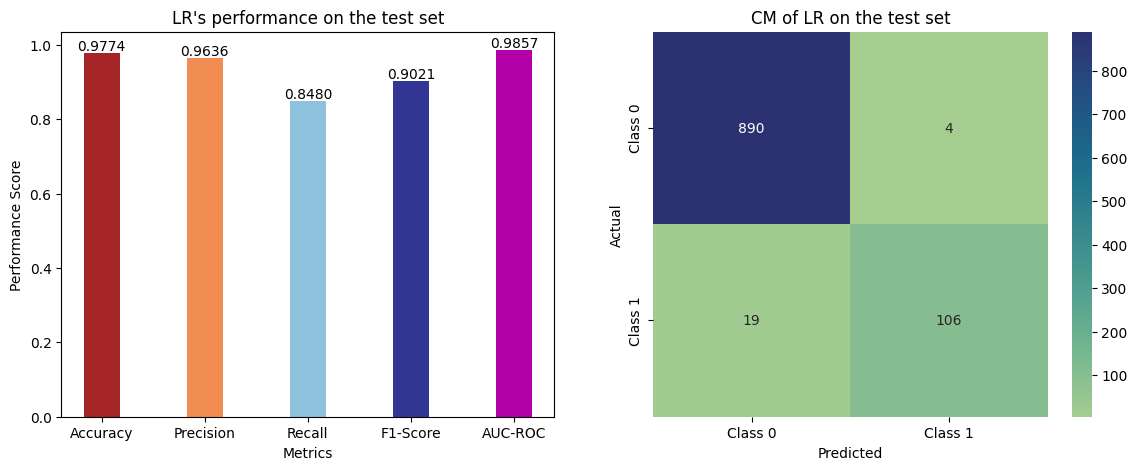

In [241]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, log_reg_5.predict(X_test)),
                                precision_score(y_test, log_reg_5.predict(X_test)),
                                recall_score(y_test, log_reg_5.predict(X_test)),
                                f1_score(y_test, log_reg_5.predict(X_test)),
                                roc_auc_score(log_reg_5, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix(model=log_reg_5, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1])

### 2.1.7. Cross validation with threshold tuning  

In [65]:
y_prob = log_reg_4.predict_proba(X_val)[:, 1]

# Threshold tuning
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    
    print(f"Threshold: {threshold}, F1: {f1}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")

y_train_prob = log_reg_4.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_prob > best_threshold).astype(int)
print("Classification report on training set:")
print(classification_report(y_train, y_train_pred))


y_test_prob = log_reg_4.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob > best_threshold).astype(int)
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Threshold: 0.2, F1: 0.5558739255014328
Threshold: 0.3, F1: 0.7599999999999999
Threshold: 0.4, F1: 0.8545454545454546
Threshold: 0.5, F1: 0.862559241706161
Threshold: 0.6, F1: 0.8743718592964824
Threshold: 0.7, F1: 0.8602150537634408
Threshold: 0.8, F1: 0.7976878612716762
Threshold: 0.9, F1: 0.5217391304347826
Best Threshold: 0.6, Best F1-Score: 0.8743718592964824
Classification report on training set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2861
           1       1.00      1.00      1.00       399

    accuracy                           1.00      3260
   macro avg       1.00      1.00      1.00      3260
weighted avg       1.00      1.00      1.00      3260

Classification report on test set:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       894
           1       0.92      0.81      0.86       125

    accuracy                           0.97      1019
   macro avg   

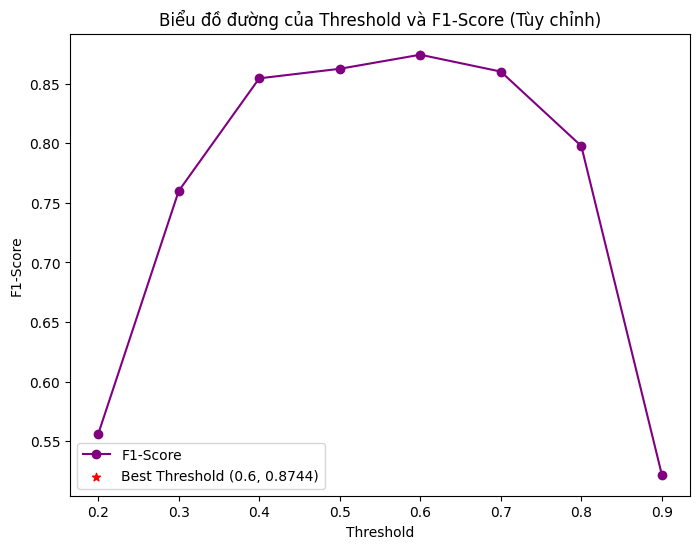

In [50]:
thresholds_custom = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
f1_scores_custom = [0.5558739255014328, 0.7599999999999999, 0.8545454545454546, 0.862559241706161,
                    0.8743718592964824, 0.8602150537634408, 0.7976878612716762, 0.5217391304347826]

# Biểu đồ đường
plt.figure(figsize=(8, 6))
plt.plot(thresholds_custom, f1_scores_custom, marker='o', linestyle='-', color='purple', label='F1-Score')
plt.scatter([0.6], [0.8743718592964824], color='r', marker='*', label='Best Threshold (0.6, 0.8744)')

# Đặt tên cho trục và biểu đồ
plt.title('Biểu đồ đường của Threshold và F1-Score (Tùy chỉnh)')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.legend()

In [242]:
overall_evaluation_with_threshold(log_reg_4, X_test, y_test, threshold=0.6)

Accuracy: 0.9676
Precision: 0.9182
Recall: 0.808
F1-score: 0.8596


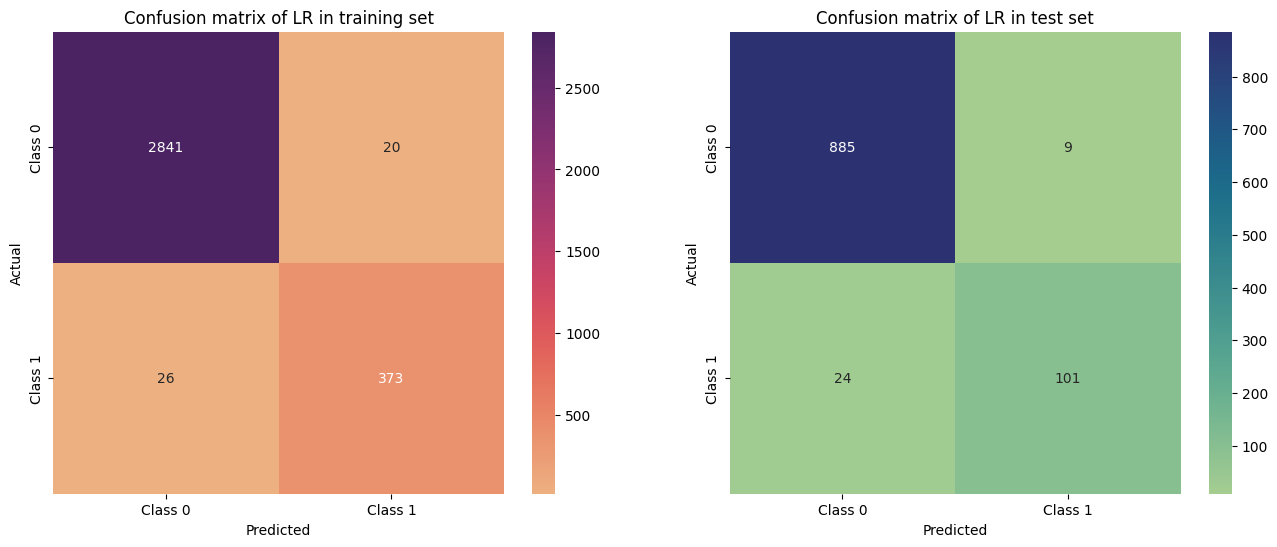

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix_threshold(model=log_reg_4, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0], threshold=0.6)
visualize_confusion_matrix_threshold(model=log_reg_4, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1], threshold=0.6)

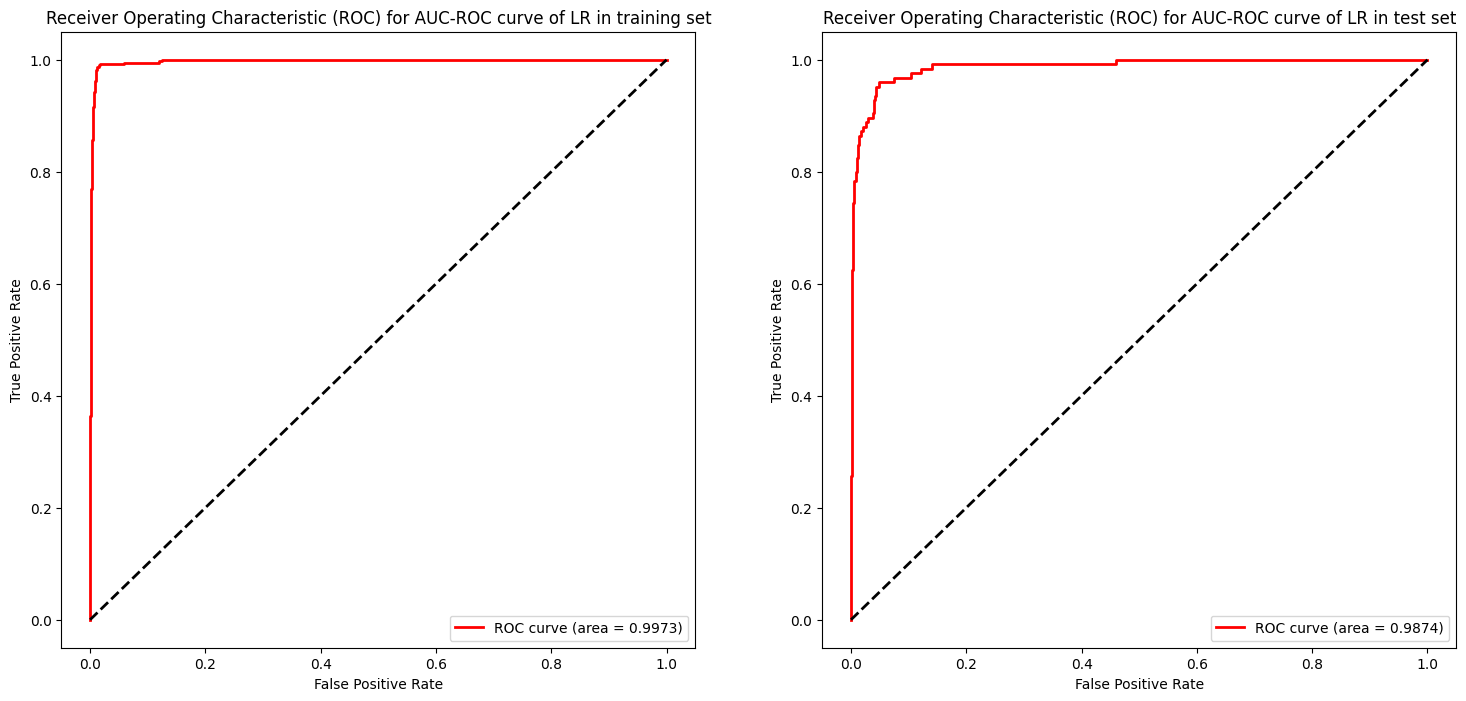

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=log_reg_4, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=log_reg_4, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

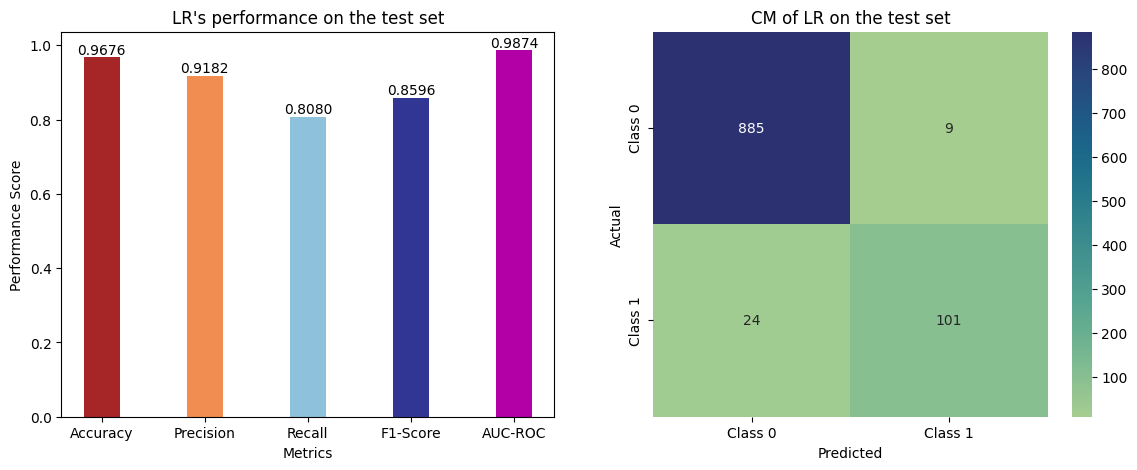

In [53]:
y_test_prob = log_reg_4.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob > 0.6).astype(int)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, y_test_pred),
                                precision_score(y_test, y_test_pred),
                                recall_score(y_test, y_test_pred),
                                f1_score(y_test, y_test_pred),
                                roc_auc_score(log_reg_4, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix_threshold(model=log_reg_4, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1], threshold=0.6)

### 2.1.8. Cross validation with best hyperparameters, best threshold

In [55]:
y_prob = log_reg_5.predict_proba(X_val)[:, 1]

# Threshold tuning
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    
    print(f"Threshold: {threshold}, F1: {f1}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")

y_train_prob = log_reg_5.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_prob > best_threshold).astype(int)
print("Classification report on training set:")
print(classification_report(y_train, y_train_pred))


y_test_prob = log_reg_5.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob > best_threshold).astype(int)
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Threshold: 0.2, F1: 0.900990099009901
Threshold: 0.3, F1: 0.9
Threshold: 0.4, F1: 0.8989898989898989
Threshold: 0.5, F1: 0.8934010152284264
Threshold: 0.6, F1: 0.9072164948453608
Threshold: 0.7, F1: 0.9005235602094239
Threshold: 0.8, F1: 0.8994708994708994
Threshold: 0.9, F1: 0.9042553191489362
Best Threshold: 0.6, Best F1-Score: 0.9072164948453608
Classification report on training set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2861
           1       1.00      0.99      0.99       399

    accuracy                           1.00      3260
   macro avg       1.00      1.00      1.00      3260
weighted avg       1.00      1.00      1.00      3260

Classification report on test set:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       894
           1       0.97      0.84      0.90       125

    accuracy                           0.98      1019
   macro avg       0.98      0

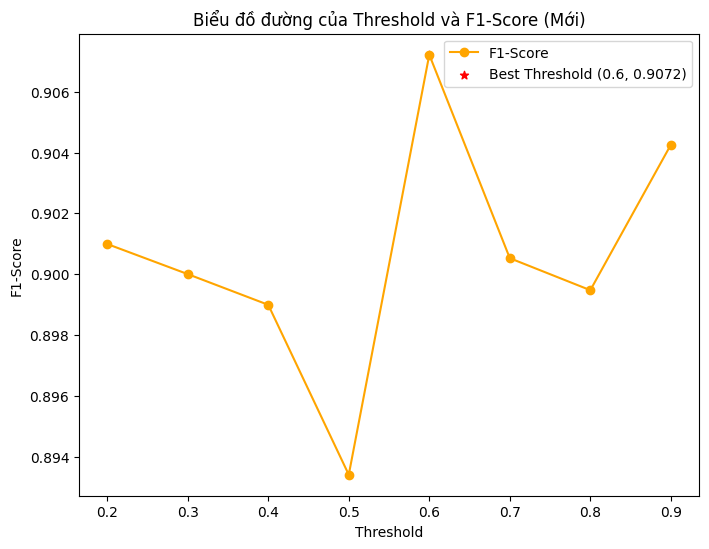

In [60]:
# Dữ liệu ngưỡng và F1-score
thresholds_new = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
f1_scores_new = [0.900990099009901, 0.9, 0.8989898989898989, 0.8934010152284264,
                 0.9072164948453608, 0.9005235602094239, 0.8994708994708994, 0.9042553191489362]

# Biểu đồ đường
plt.figure(figsize=(8, 6))
plt.plot(thresholds_new, f1_scores_new, marker='o', linestyle='-', color='orange', label='F1-Score')
plt.scatter([0.6], [0.9072164948453608], color='r', marker='*', label='Best Threshold (0.6, 0.9072)')

# Đặt tên cho trục và biểu đồ
plt.title('Biểu đồ đường của Threshold và F1-Score (Mới)')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.legend()


In [56]:
overall_evaluation_with_threshold(log_reg_5, X_test, y_test, threshold=0.6)

Accuracy: 0.9774
Precision: 0.9722
Recall: 0.84
F1-score: 0.9013


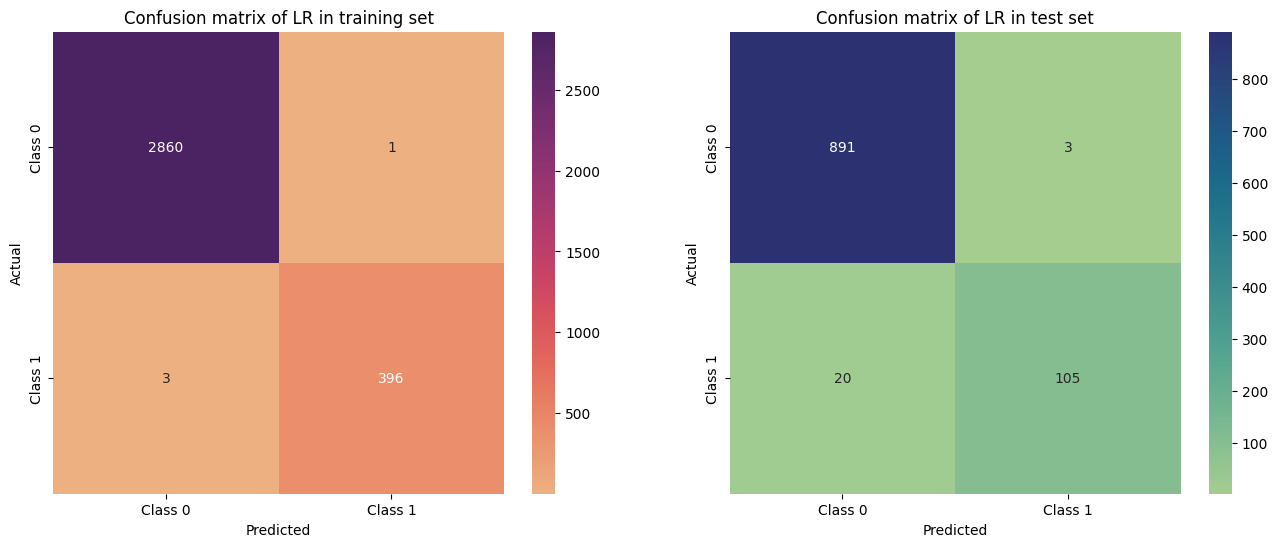

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix_threshold(model=log_reg_5, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0], threshold=0.6)
visualize_confusion_matrix_threshold(model=log_reg_5, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1], threshold=0.6)

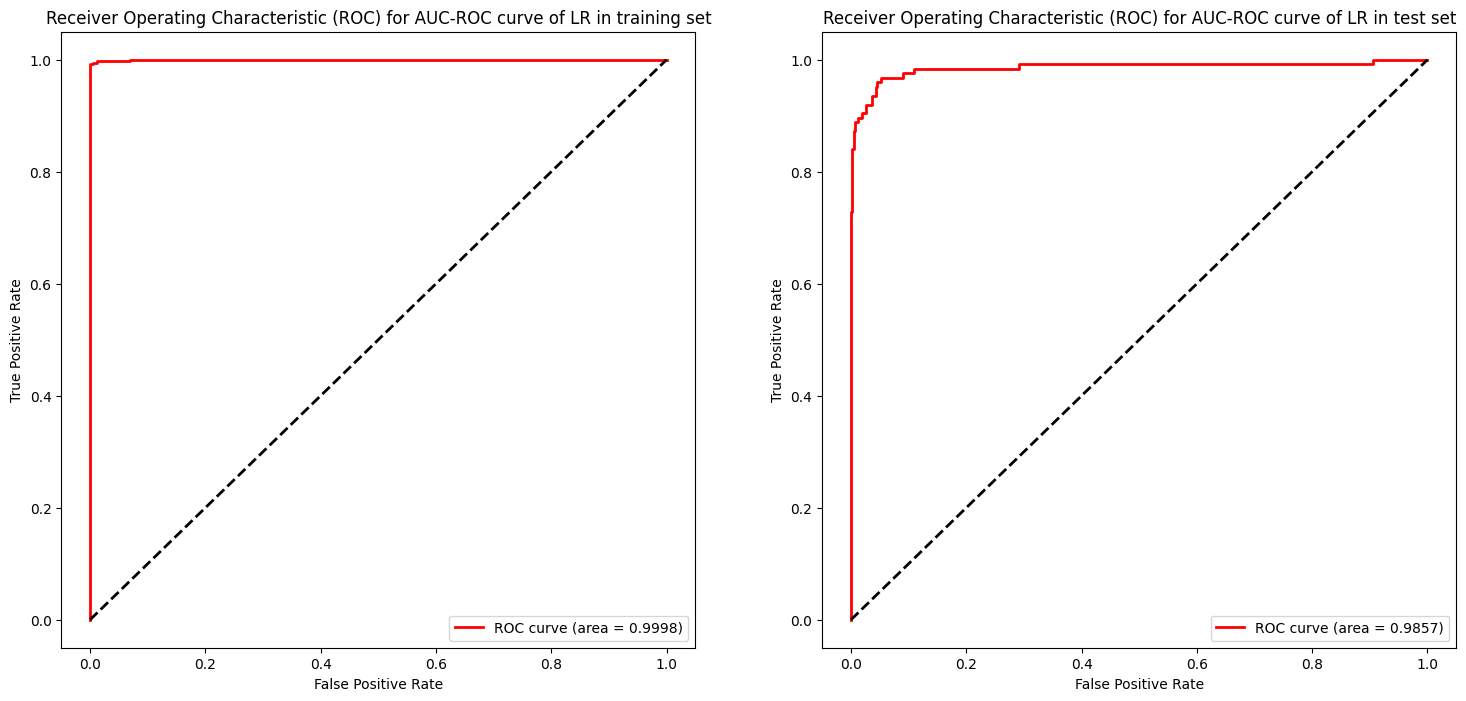

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=log_reg_5, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=log_reg_5, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

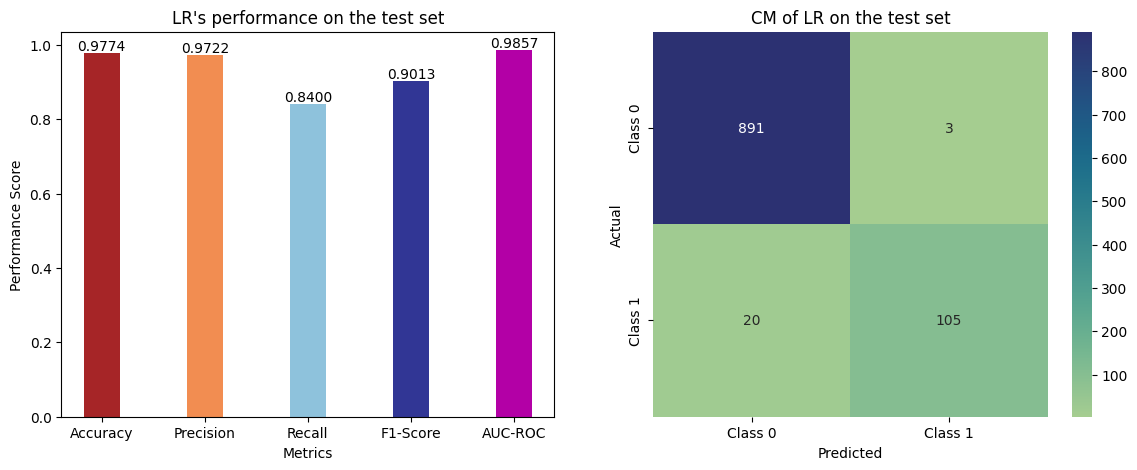

In [59]:
y_test_prob = log_reg_5.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob > 0.6).astype(int)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, y_test_pred),
                                precision_score(y_test, y_test_pred),
                                recall_score(y_test, y_test_pred),
                                f1_score(y_test, y_test_pred),
                                roc_auc_score(log_reg_5, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix_threshold(model=log_reg_5, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1], threshold=0.6)

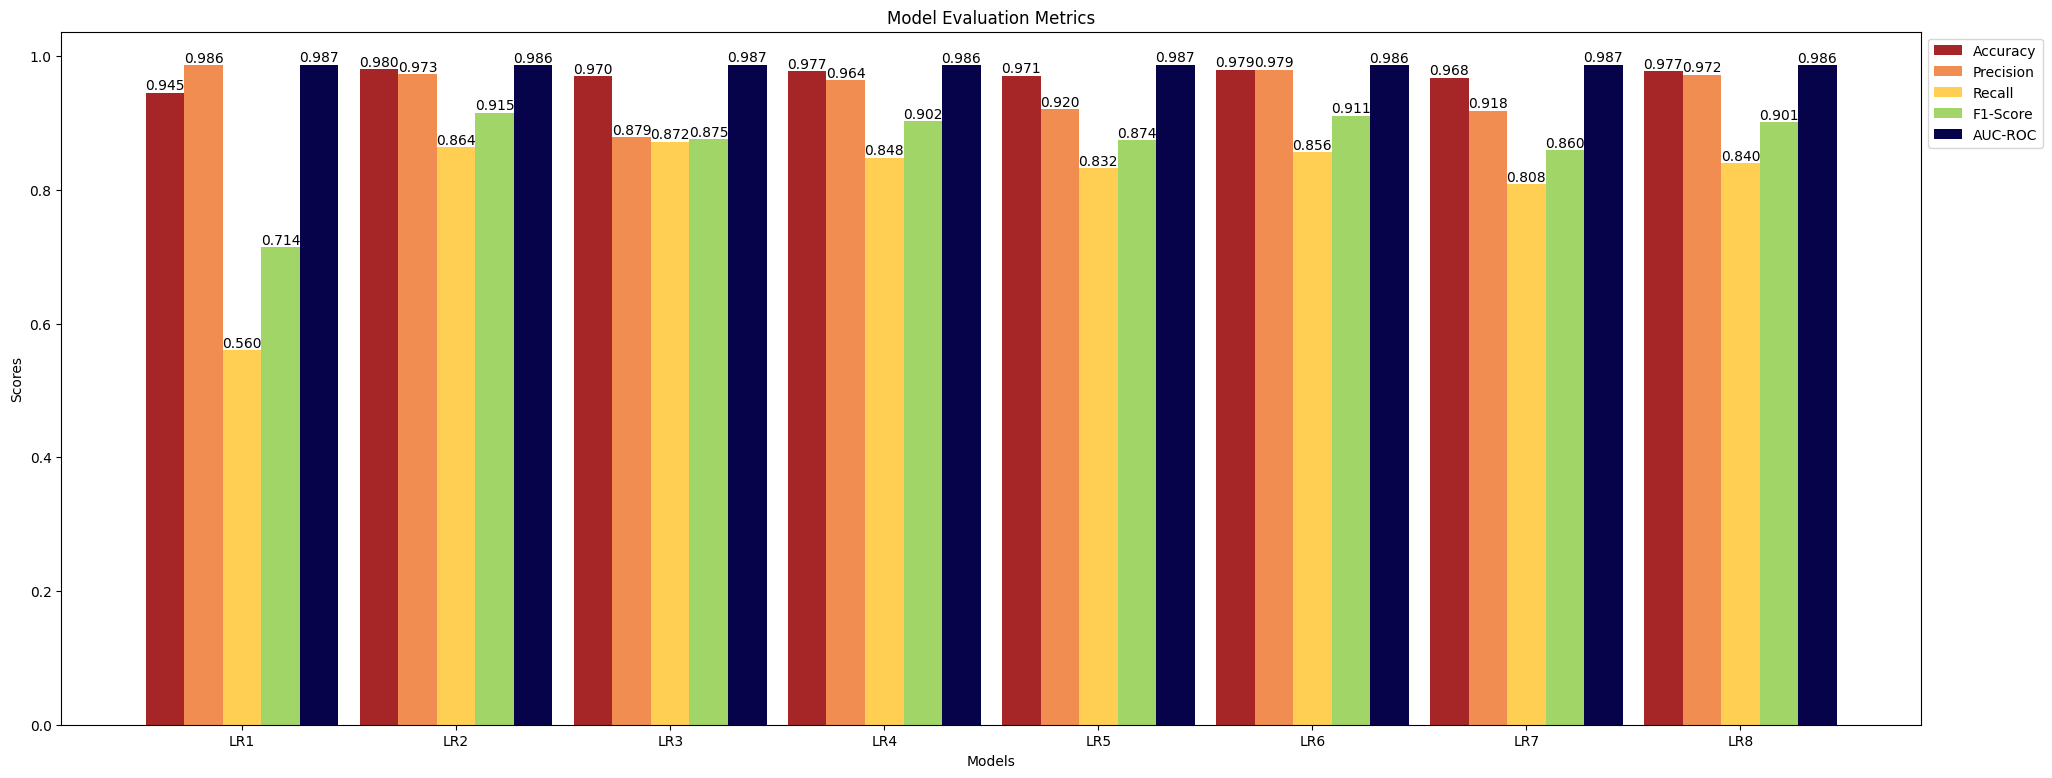

In [73]:
categories = ['LR1', 'LR2', 'LR3', 'LR4', 'LR5', 'LR6', 'LR7', 'LR8']
accuracies = [0.945, 0.98, 0.9696, 0.9774, 0.9706, 0.9794, 0.9676, 0.9774]
precisions = [0.9859, 0.973, 0.879, 0.9636, 0.9204, 0.9794, 0.9182, 0.9722]
recalls = [0.56, 0.864, 0.872, 0.848, 0.832, 0.856, 0.808, 0.84]
f1scores = [0.7143, 0.9153, 0.8755, 0.9021, 0.8739, 0.9106, 0.8596, 0.9013]
auc_rocs = [0.987, 0.986, 0.987, 0.986, 0.987, 0.986, 0.987, 0.986]

bar_width = 0.18
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(24, 9))

bar1 = ax.bar(index - 2*bar_width, accuracies, bar_width, label='Accuracy', color='#A62527')
bar2 = ax.bar(index - bar_width, precisions, bar_width, label='Precision', color='#F28D51')
bar3 = ax.bar(index, recalls, bar_width, label='Recall', color='#FFCF54')
bar4 = ax.bar(index + bar_width, f1scores, bar_width, label='F1-Score', color='#A1D568')
bar5 = ax.bar(index + 2*bar_width, auc_rocs, bar_width, label='AUC-ROC', color='#06034A')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend(bbox_to_anchor=(1, 1))

# Thêm giá trị trên đỉnh của các cột
for bars in [bar1, bar2, bar3, bar4, bar5]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom'
        )

## 2.2. Decision Tree

### 2.2.1. Default hyperparameters

In [68]:
dtc = DecisionTreeClassifier()
train_classifier(dtc, 'DT', X_train, y_train, X_test, y_test)

Classification report of DT in training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2861
           1       1.00      1.00      1.00       399

    accuracy                           1.00      3260
   macro avg       1.00      1.00      1.00      3260
weighted avg       1.00      1.00      1.00      3260

Classification report of DT in test set
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       894
           1       0.84      0.70      0.76       125

    accuracy                           0.95      1019
   macro avg       0.90      0.84      0.86      1019
weighted avg       0.94      0.95      0.94      1019



In [251]:
overall_evaluation(dtc, X_test, y_test)

Accuracy: 0.946
Precision: 0.8365
Recall: 0.696
F1-score: 0.7598


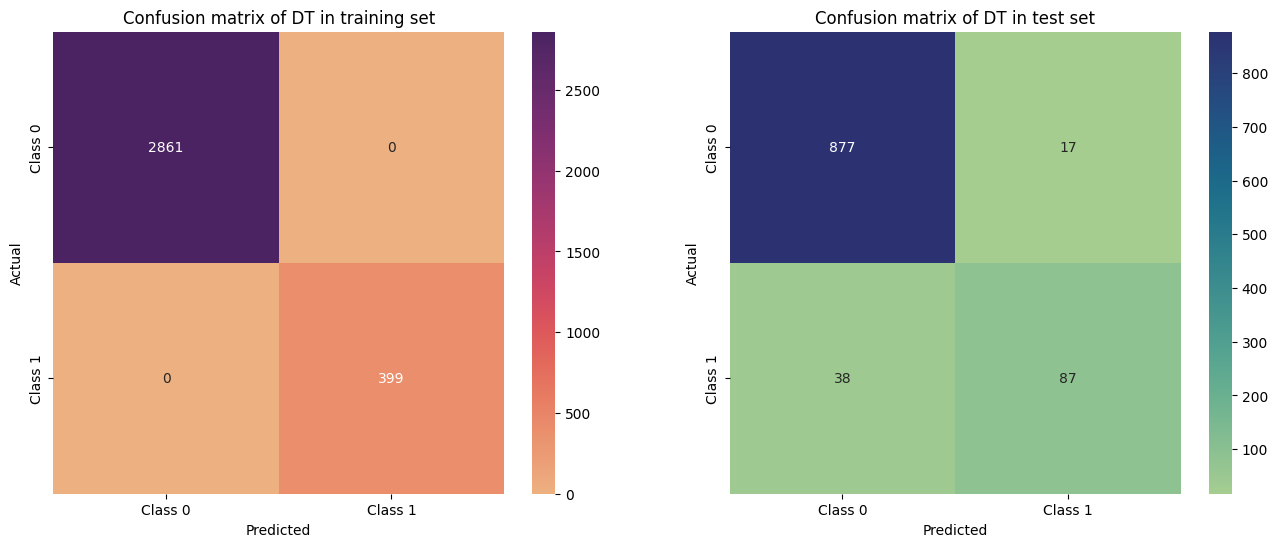

In [252]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=dtc, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of DT in training set', ax=axs[0])
visualize_confusion_matrix(model=dtc, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of DT in test set', ax=axs[1])

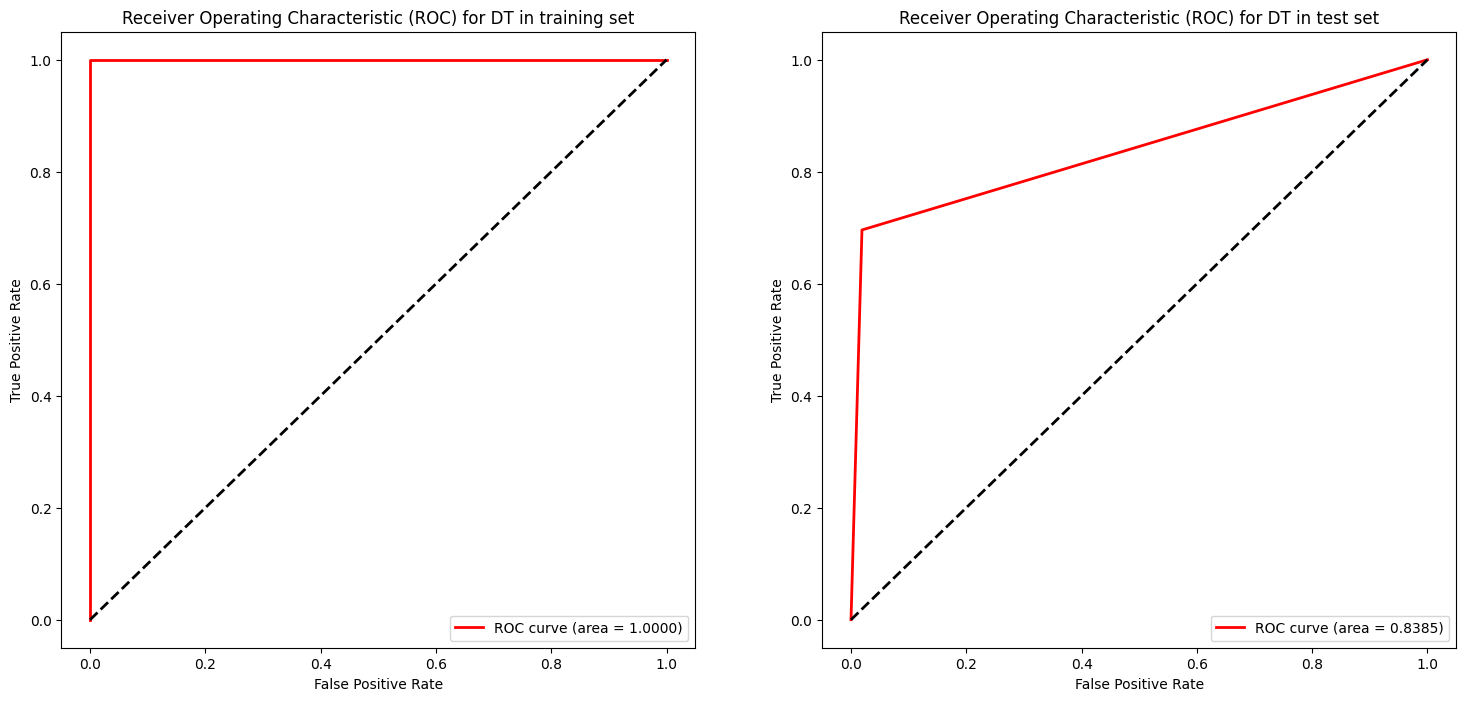

In [254]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=dtc, X_test=X_train, y_test=y_train, model_name='DT in training set', ax=ax[0])
visualize_auc_roc_curve(model=dtc, X_test=X_test, y_test=y_test, model_name='DT in test set', ax=ax[1])

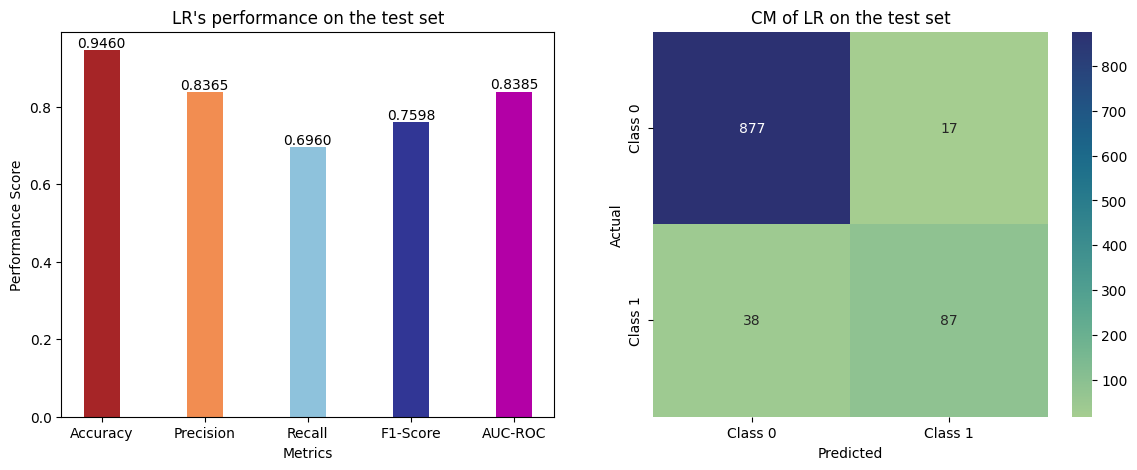

In [255]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, dtc.predict(X_test)),
                                precision_score(y_test, dtc.predict(X_test)),
                                recall_score(y_test, dtc.predict(X_test)),
                                f1_score(y_test, dtc.predict(X_test)),
                                roc_auc_score(dtc, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix(model=dtc, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1])

### 2.2.2. Hyperparameters tuning

In [157]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid,
    scoring='f1',
    cv=10, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Best hyperparameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}

Best hyperparameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}


In [167]:
# scoring='f1':
#   - cv=5:
#        class_weight=None, criterion='entropy', max_depth=20, min_samples_leaf=1, min_samples_split=5, splitter='random'
#   - cv=10:
#        'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'
#   - cv=15:
#        C=1000, class_weight='balanced', fit_intercept=True, max_iter=10, penalty='l2', solver='newton-cg'

dtc_2 = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=10, splitter='random')
train_classifier(dtc_2, 'DT', X_train, y_train, X_test, y_test)

Classification report of DT in training set
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2861
           1       0.93      1.00      0.97       399

    accuracy                           0.99      3260
   macro avg       0.97      1.00      0.98      3260
weighted avg       0.99      0.99      0.99      3260

Classification report of DT in test set
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       894
           1       0.82      0.80      0.81       125

    accuracy                           0.95      1019
   macro avg       0.90      0.89      0.89      1019
weighted avg       0.95      0.95      0.95      1019



In [256]:
overall_evaluation(dtc_2, X_test, y_test)

Accuracy: 0.9539
Precision: 0.8197
Recall: 0.8
F1-score: 0.8097


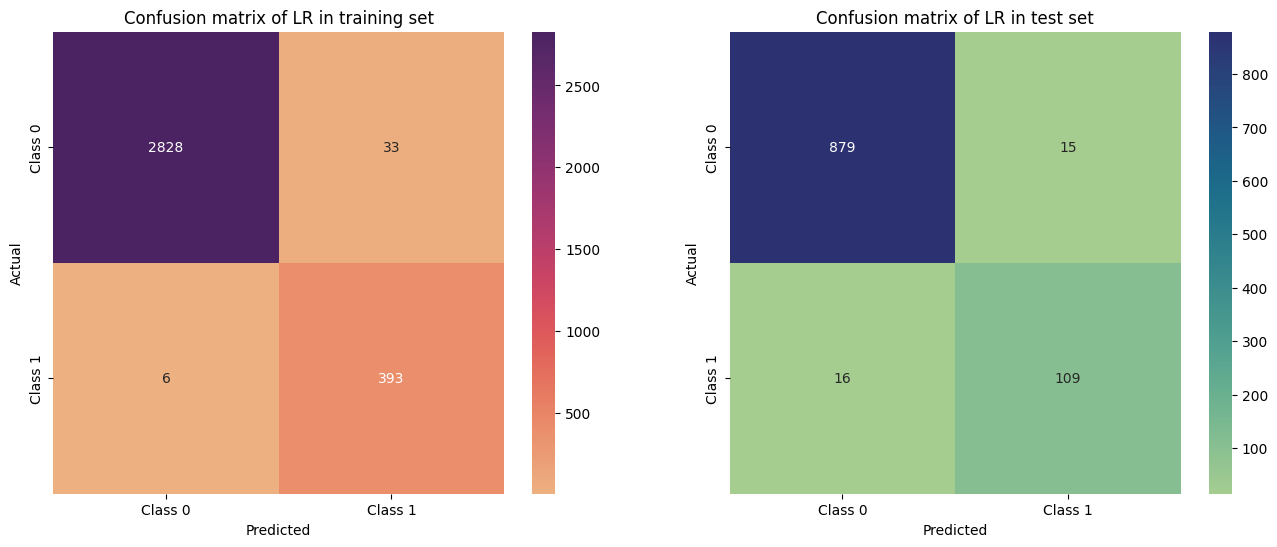

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=dtc_2, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=dtc_2, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

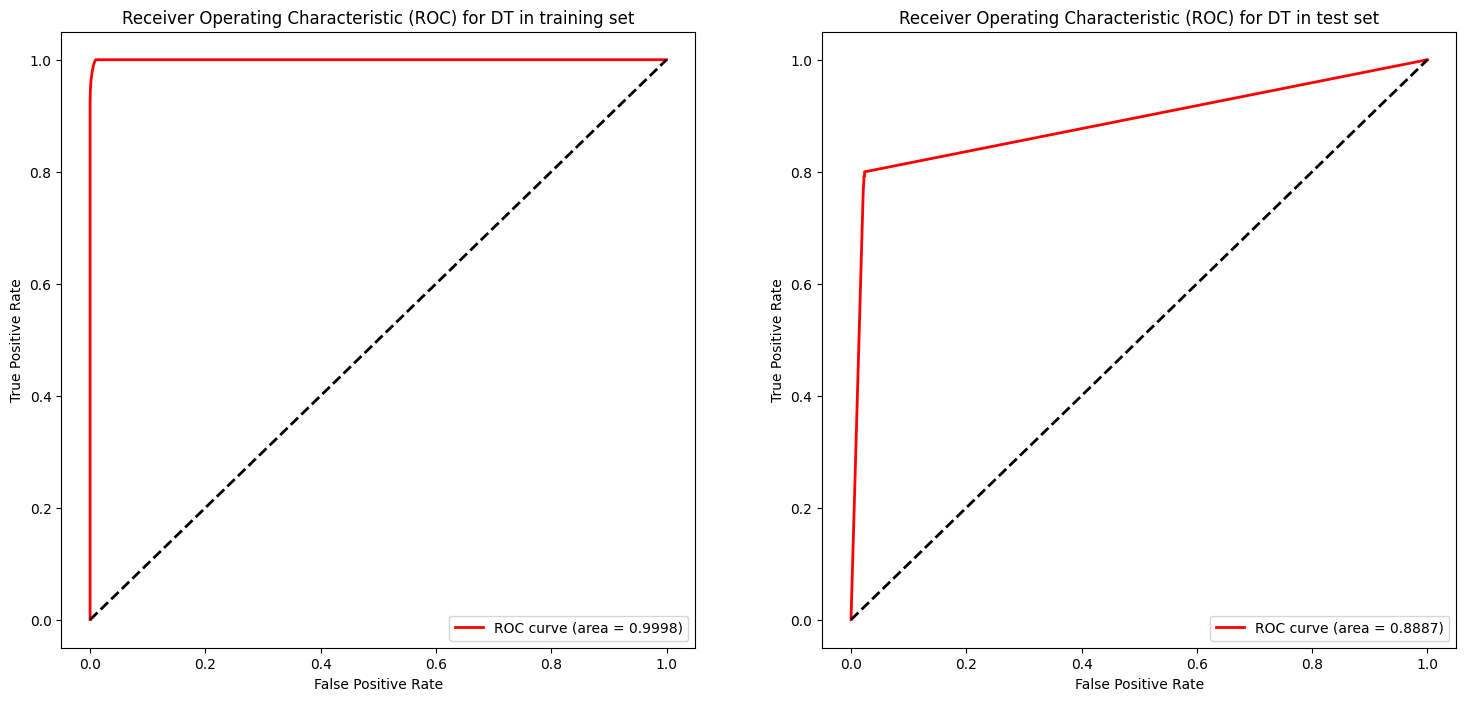

In [258]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=dtc_2, X_test=X_train, y_test=y_train, model_name='DT in training set', ax=ax[0])
visualize_auc_roc_curve(model=dtc_2, X_test=X_test, y_test=y_test, model_name='DT in test set', ax=ax[1])

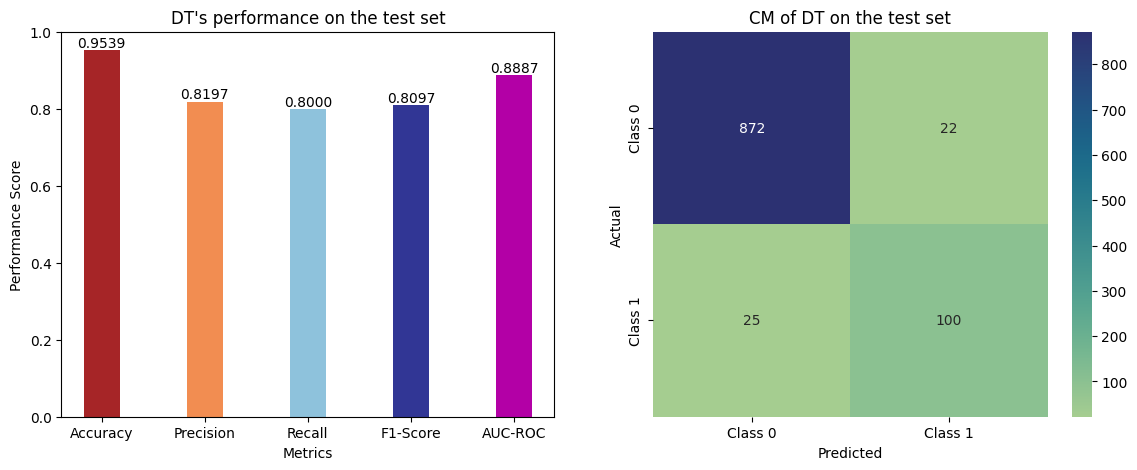

In [260]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, dtc_2.predict(X_test)),
                                precision_score(y_test, dtc_2.predict(X_test)),
                                recall_score(y_test, dtc_2.predict(X_test)),
                                f1_score(y_test, dtc_2.predict(X_test)),
                                roc_auc_score(dtc_2, X_test, y_test),
                                model_name='DT',
                                ax=axs[0])
visualize_confusion_matrix(model=dtc_2, X=X_test, y=y_test, cmap='crest', title='CM of DT on the test set', ax=axs[1])

### 2.2.3. Cross validation

In [168]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a logistic regression model
dtc_3 = DecisionTreeClassifier(class_weight='balanced')

X_train_arr = X_train.toarray()

# Variables to store overall performance metrics
total_accuracy_train = 0
total_accuracy_test = 0

# Metrics history
fold_numbers = list(range(1, 11))
training_accuracy_history = []
test_accuracy_history = []
training_precision_history = []
test_precision_history = []
training_recall_history = []
test_recall_history = []
training_f1score_history = []
test_f1score_history = []
i = 0

# Perform KFold cross-validation
for train_index, test_index in skf.split(X_train_arr, y_train):
    X_train_f, X_test_f = X_train_arr[train_index], X_train_arr[test_index]
    y_train_f, y_test_f = y_train.iloc[train_index], y_train.iloc[test_index]  # Sử dụng iloc để lấy dữ liệu từ DataFrame

    # Train the model
    dtc_3.fit(X_train_f, y_train_f)

    # Make predictions
    y_train_pred = dtc_3.predict(X_train_f)
    y_test_pred = dtc_3.predict(X_test_f)

    # Log all values for model evaluation
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    precision_train = precision_score(y_train_f, y_train_pred)
    precision_test = precision_score(y_test_f, y_test_pred)
    recall_train = recall_score(y_train_f, y_train_pred)
    recall_test = recall_score(y_test_f, y_test_pred)
    f1_train = f1_score(y_train_f, y_train_pred)
    f1_test = f1_score(y_test_f, y_test_pred)

    # Append values to the history lists
    training_accuracy_history.append(accuracy_train)
    test_accuracy_history.append(accuracy_test)
    training_precision_history.append(precision_train)
    test_precision_history.append(precision_test)
    training_recall_history.append(recall_train)
    test_recall_history.append(recall_test)
    training_f1score_history.append(f1_train)
    test_f1score_history.append(f1_test)

    # Evaluate the model
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    total_accuracy_train += accuracy_train
    total_accuracy_test += accuracy_test

    # Print classification report and confusion matrix for each fold
    print(f'\nFold {i + 1}:')
    print(f'Accuracy (Train): {accuracy_train}')
    print('Classification Report (Train):')
    print(classification_report(y_train_f, y_train_pred))

    print('Confusion Matrix (Train):')
    print(confusion_matrix(y_train_f, y_train_pred))

    print(f'Accuracy (Test): {accuracy_test}')
    print('Classification Report (Test):')
    print(classification_report(y_test_f, y_test_pred))

    print('Confusion Matrix (Test):')
    print(confusion_matrix(y_test_f, y_test_pred))

    i+=1

# Calculate the average accuracy over all folds
average_accuracy_train = total_accuracy_train / n_splits
average_accuracy_test = total_accuracy_test / n_splits

print(f'Average Training Accuracy: {average_accuracy_train}')
print(f'Average Testing Accuracy: {average_accuracy_test}')


Fold 1:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2574
           1       1.00      1.00      1.00       360

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2574    0]
 [   0  360]]
Accuracy (Test): 0.9447852760736196
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       287
           1       0.72      0.87      0.79        39

    accuracy                           0.94       326
   macro avg       0.85      0.91      0.88       326
weighted avg       0.95      0.94      0.95       326

Confusion Matrix (Test):
[[274  13]
 [  5  34]]

Fold 2:
Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support



In [171]:
evaluation(dtc_3, X_train, y_train, 'Classification report on training set:', metric=classification_report)
print()
evaluation(dtc_3, X_test, y_test, 'Classification report on test set:', metric=classification_report)

Classification report on training set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2861
           1       0.97      0.98      0.98       399

    accuracy                           0.99      3260
   macro avg       0.98      0.99      0.99      3260
weighted avg       0.99      0.99      0.99      3260


Classification report on test set:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       894
           1       0.73      0.80      0.76       125

    accuracy                           0.94      1019
   macro avg       0.85      0.88      0.86      1019
weighted avg       0.94      0.94      0.94      1019



In [261]:
overall_evaluation(dtc_3, X_test, y_test)

Accuracy: 0.9392
Precision: 0.7299
Recall: 0.8
F1-score: 0.7634


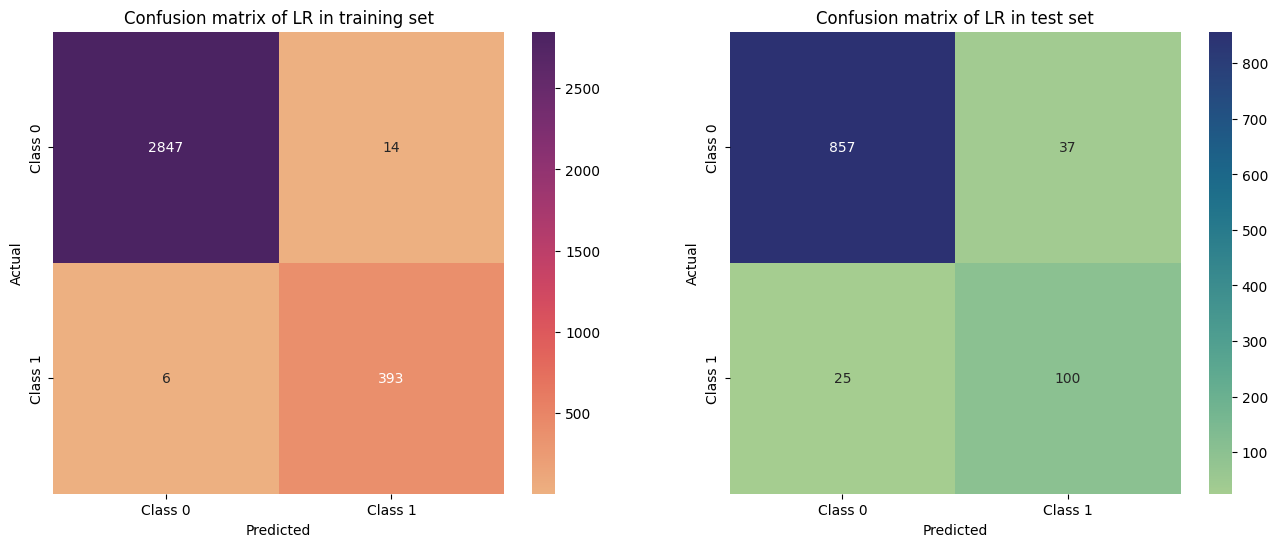

In [262]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=dtc_3, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=dtc_3, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

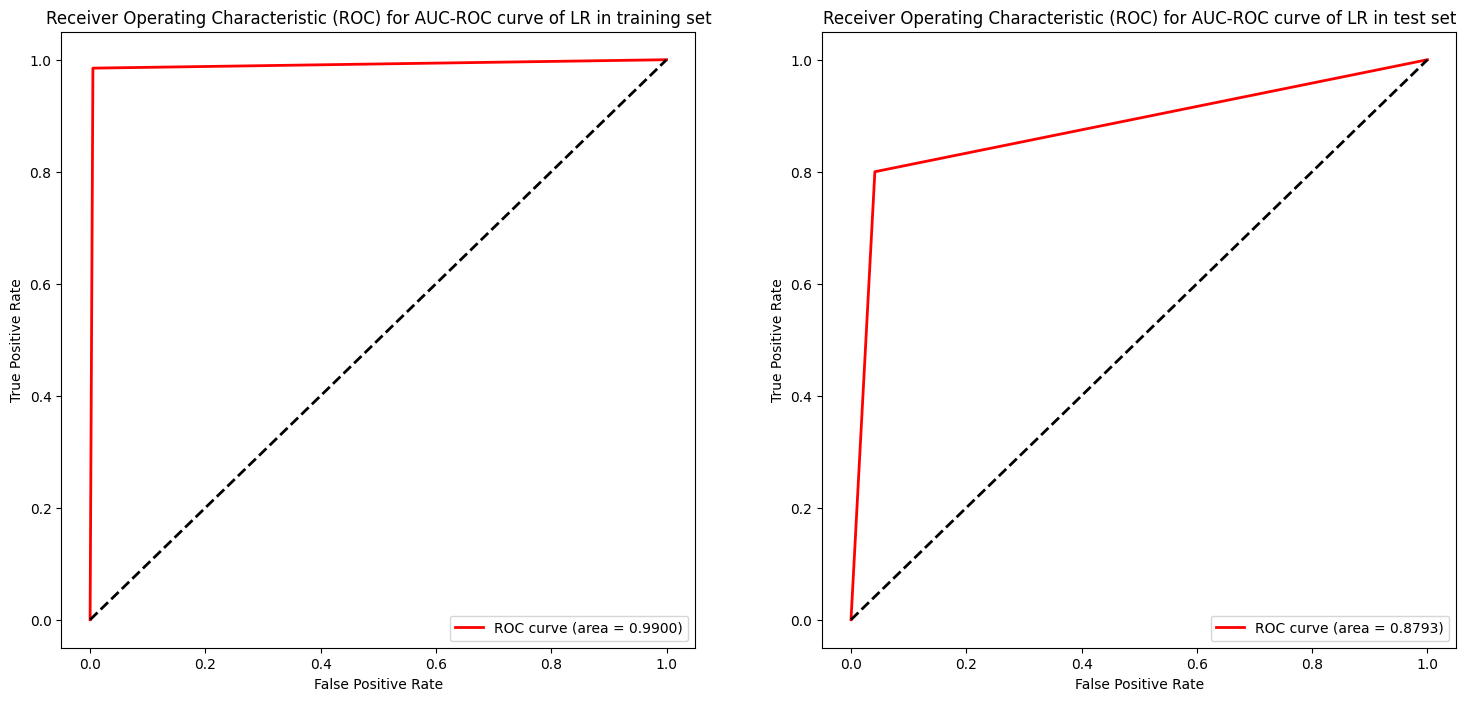

In [263]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=dtc_3, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=dtc_3, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

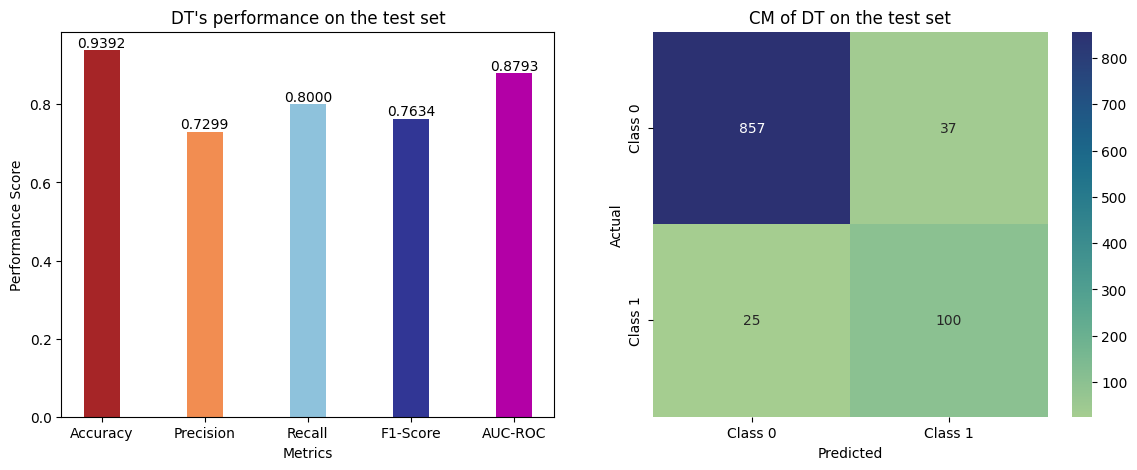

In [264]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, dtc_3.predict(X_test)),
                                precision_score(y_test, dtc_3.predict(X_test)),
                                recall_score(y_test, dtc_3.predict(X_test)),
                                f1_score(y_test, dtc_3.predict(X_test)),
                                roc_auc_score(dtc_3, X_test, y_test),
                                model_name='DT',
                                ax=axs[0])
visualize_confusion_matrix(model=dtc_3, X=X_test, y=y_test, cmap='crest', title='CM of DT on the test set', ax=axs[1])

### 2.2.4. Cross validation with hyperparameters tuning

In [176]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a logistic regression model
dtc_4 = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=10, splitter='random')

X_train_arr = X_train.toarray()

# Variables to store overall performance metrics
total_accuracy_train = 0
total_accuracy_test = 0

# Metrics history
fold_numbers = list(range(1, 11))
training_accuracy_history = []
test_accuracy_history = []
training_precision_history = []
test_precision_history = []
training_recall_history = []
test_recall_history = []
training_f1score_history = []
test_f1score_history = []
i = 0

# Perform KFold cross-validation
for train_index, test_index in skf.split(X_train_arr, y_train):
    X_train_f, X_test_f = X_train_arr[train_index], X_train_arr[test_index]
    y_train_f, y_test_f = y_train.iloc[train_index], y_train.iloc[test_index]  # Sử dụng iloc để lấy dữ liệu từ DataFrame

    # Train the model
    dtc_4.fit(X_train_f, y_train_f)

    # Make predictions
    y_train_pred = dtc_4.predict(X_train_f)
    y_test_pred = dtc_4.predict(X_test_f)

    # Log all values for model evaluation
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    precision_train = precision_score(y_train_f, y_train_pred)
    precision_test = precision_score(y_test_f, y_test_pred)
    recall_train = recall_score(y_train_f, y_train_pred)
    recall_test = recall_score(y_test_f, y_test_pred)
    f1_train = f1_score(y_train_f, y_train_pred)
    f1_test = f1_score(y_test_f, y_test_pred)

    # Append values to the history lists
    training_accuracy_history.append(accuracy_train)
    test_accuracy_history.append(accuracy_test)
    training_precision_history.append(precision_train)
    test_precision_history.append(precision_test)
    training_recall_history.append(recall_train)
    test_recall_history.append(recall_test)
    training_f1score_history.append(f1_train)
    test_f1score_history.append(f1_test)

    # Evaluate the model
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    total_accuracy_train += accuracy_train
    total_accuracy_test += accuracy_test

    # Print classification report and confusion matrix for each fold
    print(f'\nFold {i + 1}:')
    print(f'Accuracy (Train): {accuracy_train}')
    print('Classification Report (Train):')
    print(classification_report(y_train_f, y_train_pred))

    print('Confusion Matrix (Train):')
    print(confusion_matrix(y_train_f, y_train_pred))

    print(f'Accuracy (Test): {accuracy_test}')
    print('Classification Report (Test):')
    print(classification_report(y_test_f, y_test_pred))

    print('Confusion Matrix (Test):')
    print(confusion_matrix(y_test_f, y_test_pred))

    i+=1

# Calculate the average accuracy over all folds
average_accuracy_train = total_accuracy_train / n_splits
average_accuracy_test = total_accuracy_test / n_splits

print(f'Average Training Accuracy: {average_accuracy_train}')
print(f'Average Testing Accuracy: {average_accuracy_test}')


Fold 1:
Accuracy (Train): 0.9911383776414451
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2574
           1       0.93      1.00      0.97       360

    accuracy                           0.99      2934
   macro avg       0.97      0.99      0.98      2934
weighted avg       0.99      0.99      0.99      2934

Confusion Matrix (Train):
[[2548   26]
 [   0  360]]
Accuracy (Test): 0.950920245398773
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       287
           1       0.78      0.82      0.80        39

    accuracy                           0.95       326
   macro avg       0.88      0.89      0.89       326
weighted avg       0.95      0.95      0.95       326

Confusion Matrix (Test):
[[278   9]
 [  7  32]]

Fold 2:
Accuracy (Train): 0.9870483980913429
Classification Report (Train):
              precision   

In [177]:
evaluation(dtc_4, X_train, y_train, 'Classification report on training set:', metric=classification_report)
print()
evaluation(dtc_4, X_test, y_test, 'Classification report on test set:', metric=classification_report)

Classification report on training set:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2861
           1       0.91      0.98      0.94       399

    accuracy                           0.98      3260
   macro avg       0.95      0.98      0.97      3260
weighted avg       0.99      0.98      0.99      3260


Classification report on test set:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       894
           1       0.79      0.75      0.77       125

    accuracy                           0.95      1019
   macro avg       0.88      0.86      0.87      1019
weighted avg       0.94      0.95      0.94      1019



In [265]:
overall_evaluation(dtc_4, X_test, y_test)

Accuracy: 0.945
Precision: 0.7899
Recall: 0.752
F1-score: 0.7705


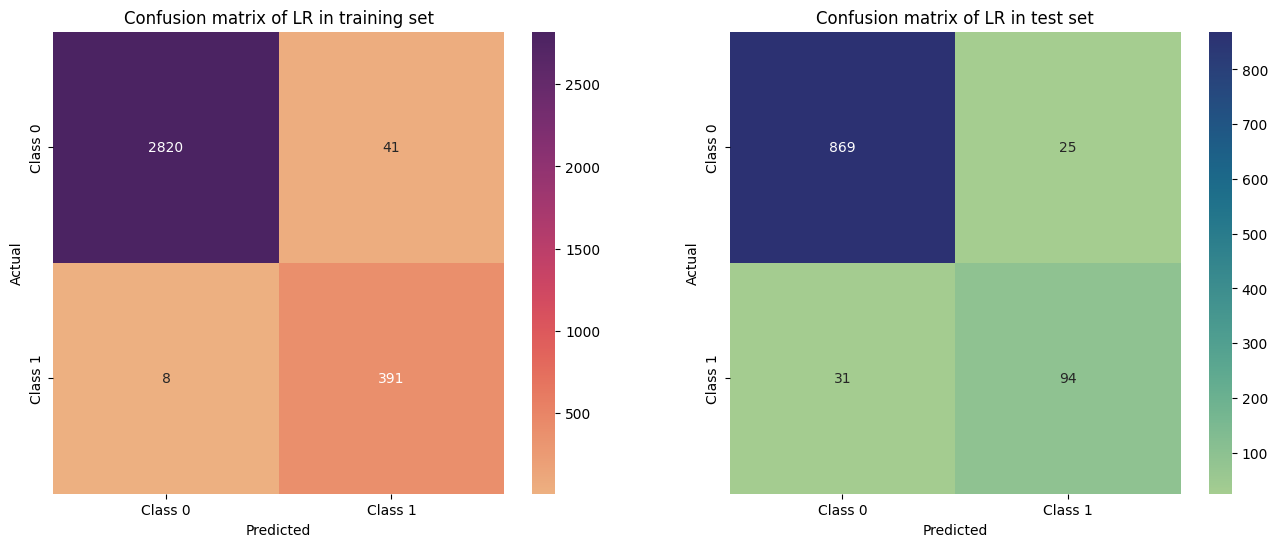

In [266]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=dtc_4, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=dtc_4, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

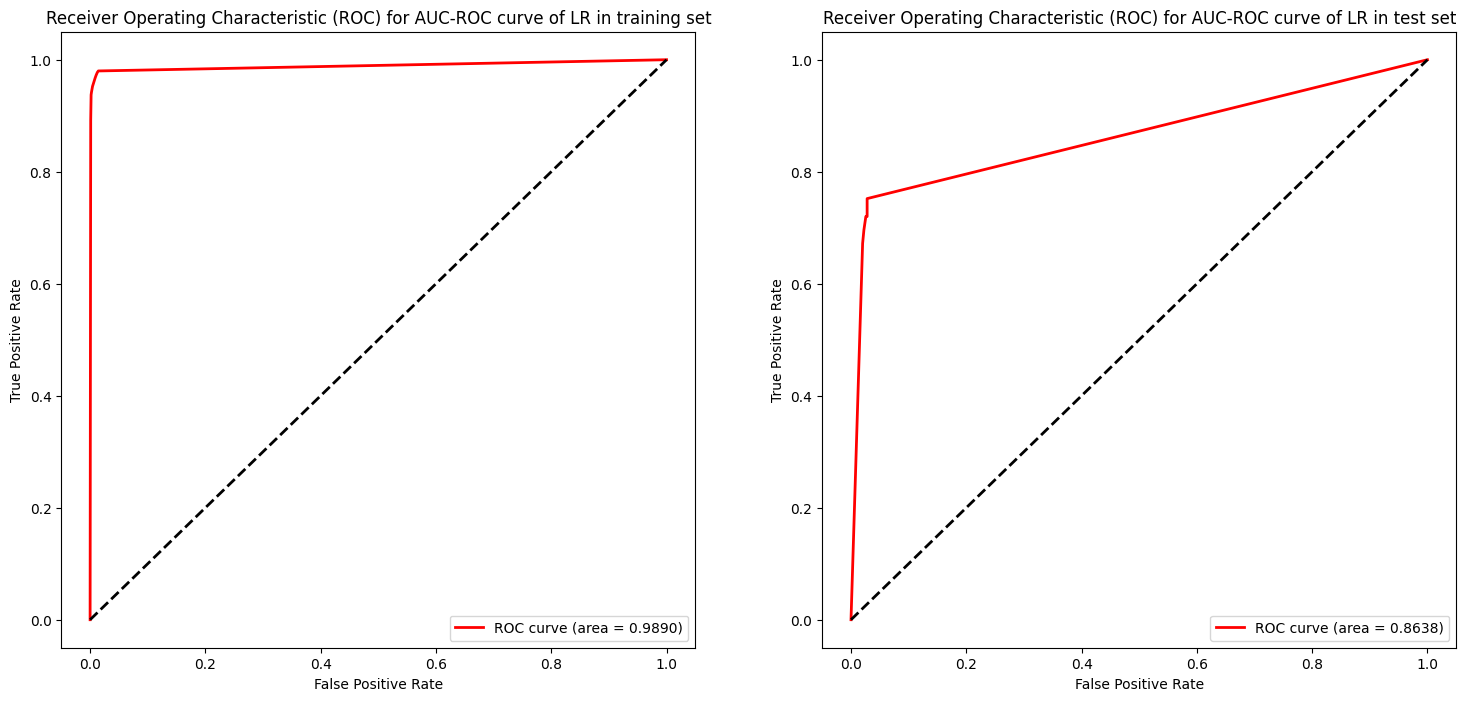

In [267]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=dtc_4, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=dtc_4, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

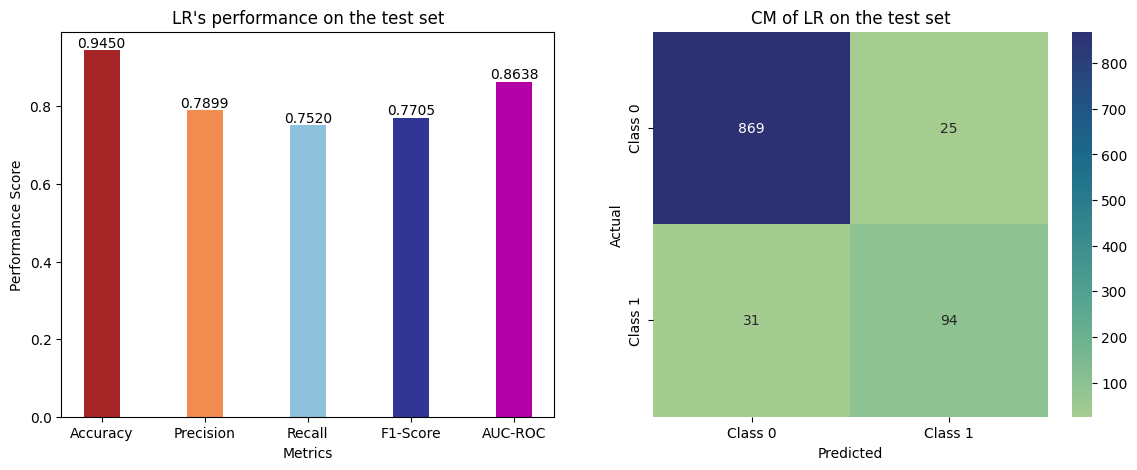

In [268]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, dtc_4.predict(X_test)),
                                precision_score(y_test, dtc_4.predict(X_test)),
                                recall_score(y_test, dtc_4.predict(X_test)),
                                f1_score(y_test, dtc_4.predict(X_test)),
                                roc_auc_score(dtc_4, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix(model=dtc_4, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1])

## 2.3. SVM

### 2.3.1. Default hyperparameters

In [74]:
svc = SVC(probability=True)
train_classifier(svc, 'SVM', X_train, y_train, X_test, y_test)

Classification report of SVM in training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2861
           1       1.00      0.97      0.99       399

    accuracy                           1.00      3260
   macro avg       1.00      0.99      0.99      3260
weighted avg       1.00      1.00      1.00      3260

Classification report of SVM in test set
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       894
           1       0.99      0.74      0.85       125

    accuracy                           0.97      1019
   macro avg       0.98      0.87      0.92      1019
weighted avg       0.97      0.97      0.97      1019



In [75]:
overall_evaluation(svc, X_test, y_test)

Accuracy: 0.9676
Precision: 0.9894
Recall: 0.744
F1-score: 0.8493


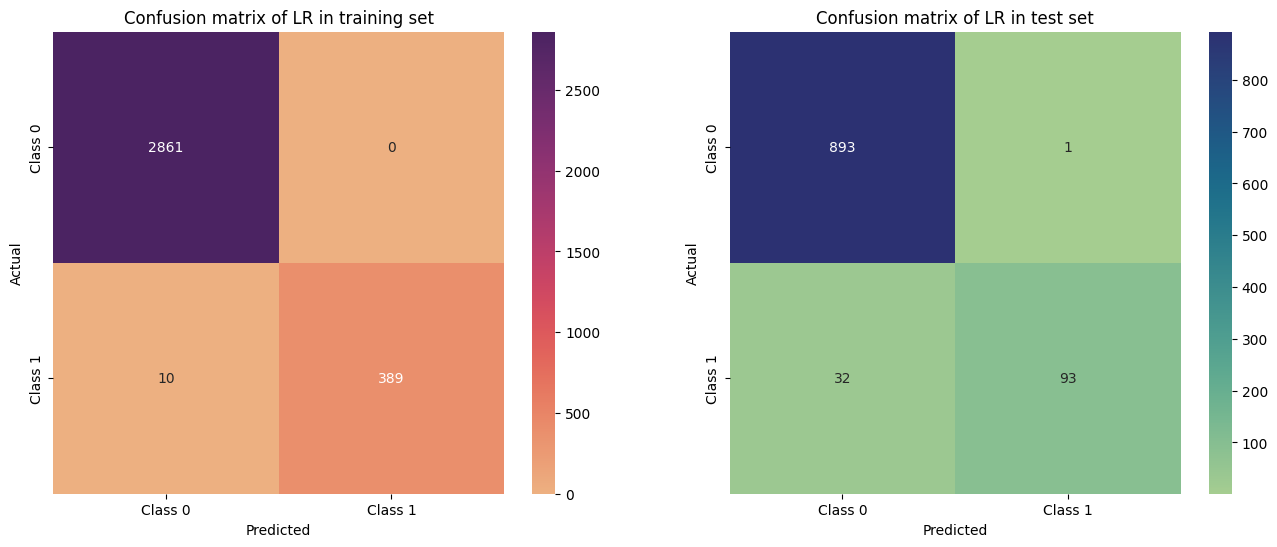

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=svc, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=svc, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

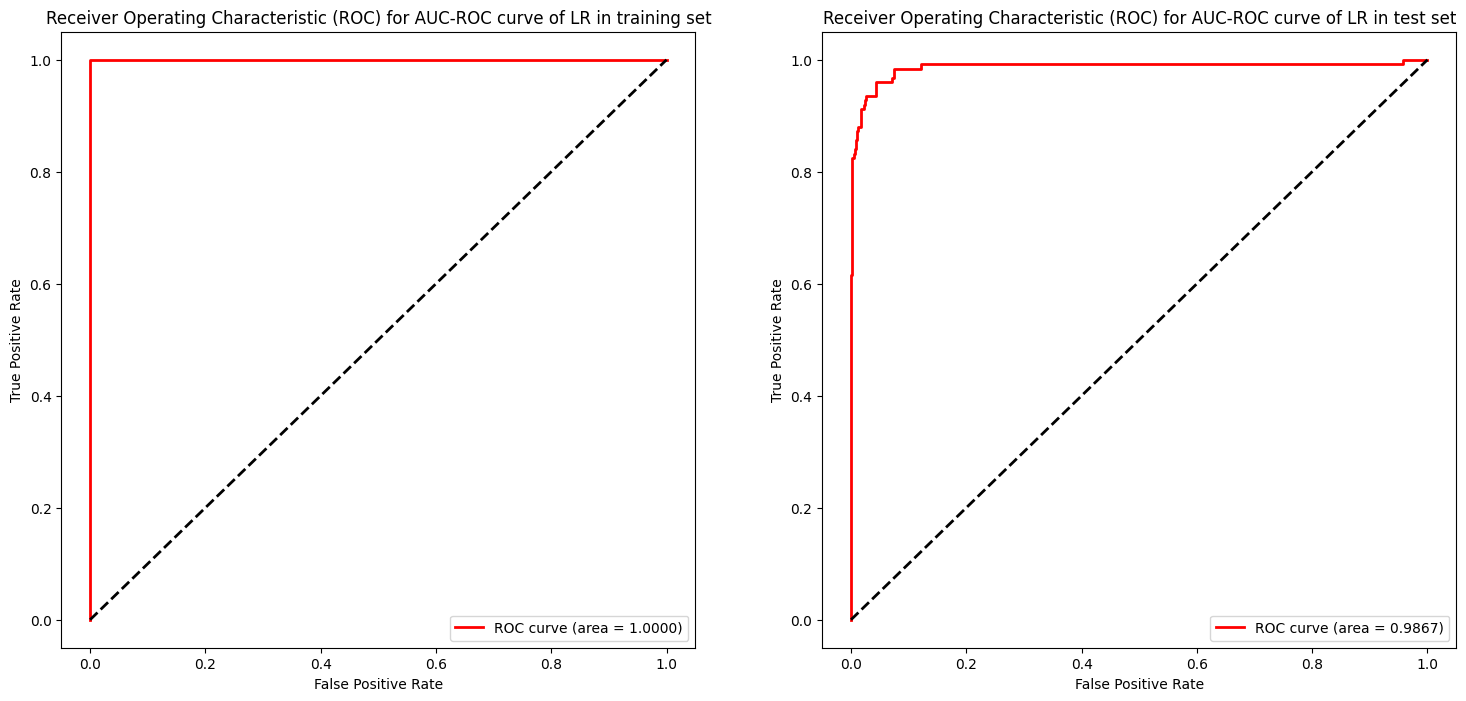

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=svc, X_test=X_train, y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=svc, X_test=X_test, y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

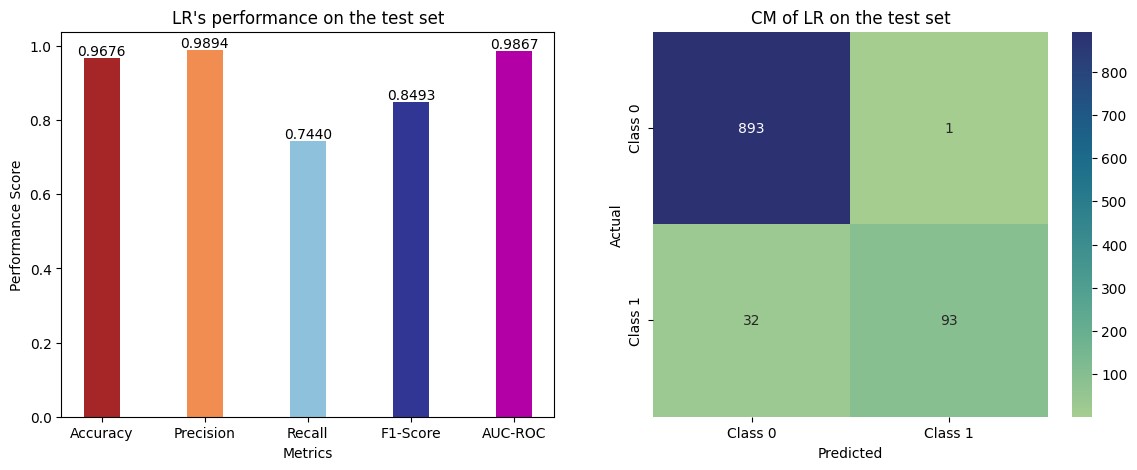

In [276]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, svc.predict(X_test)),
                                precision_score(y_test, svc.predict(X_test)),
                                recall_score(y_test, svc.predict(X_test)),
                                f1_score(y_test, svc.predict(X_test)),
                                roc_auc_score(svc, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix(model=svc, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1])

### 2.2.2. Hyperparameters tuning

In [189]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'probability': [False, True]
}

grid_search = GridSearchCV(
    SVC(),
    param_grid,
    scoring='f1',
    cv=15, 
    n_jobs=-1
)

grid_search.fit(X_val, y_val)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Best hyperparameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid', 'probability': False}

Best hyperparameters: {'C': 10, 'class_weight': None, 'gamma': 0.1, 'kernel': 'rbf', 'probability': False}


In [80]:
# scoring='f1':
#   - cv=5:
#        C=1, class_weight='balanced', gamma='scale', kernel='sigmoid', probability=False
#   - cv=10:
#        C=10, class_weight='balanced', gamma=0.1, kernel='rbf', probability=False
#   - cv=15:
#        C=10, class_weight=None, gamma=0.1, kernel='rbf', probability=False

svc_2 = SVC(C=10, class_weight='balanced', gamma=0.1, kernel='rbf', probability=True)
train_classifier(svc_2, 'SVM', X_train, y_train, X_test, y_test)

Classification report of SVM in training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2861
           1       1.00      1.00      1.00       399

    accuracy                           1.00      3260
   macro avg       1.00      1.00      1.00      3260
weighted avg       1.00      1.00      1.00      3260

Classification report of SVM in test set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       894
           1       0.96      0.86      0.90       125

    accuracy                           0.98      1019
   macro avg       0.97      0.93      0.95      1019
weighted avg       0.98      0.98      0.98      1019



In [81]:
overall_evaluation(svc_2, X_test, y_test)

Accuracy: 0.9774
Precision: 0.9554
Recall: 0.856
F1-score: 0.903


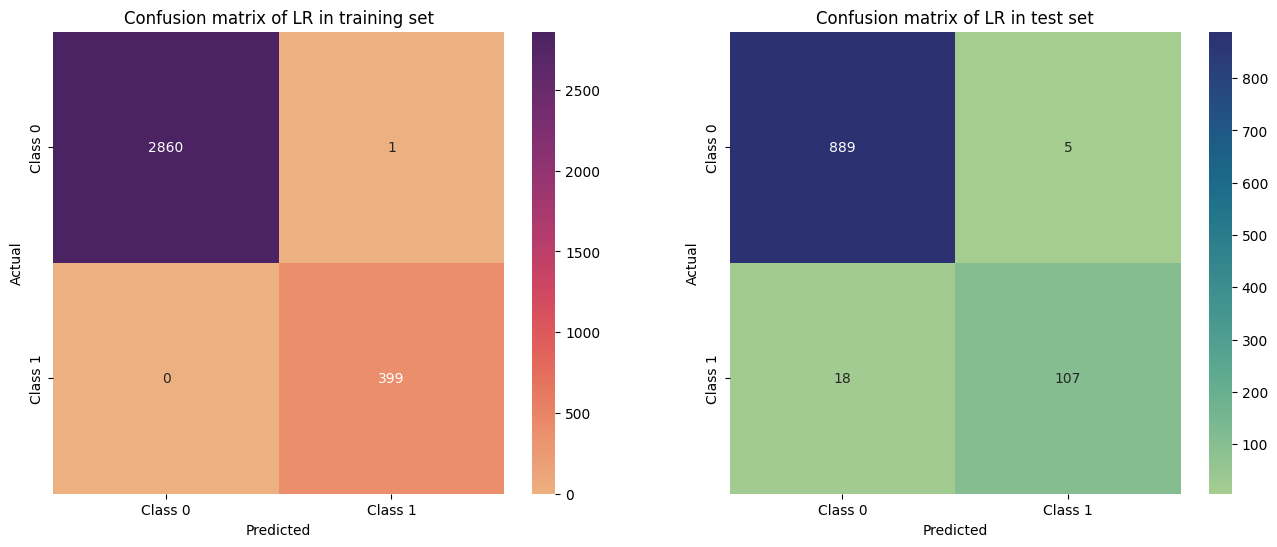

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=svc_2, X=X_train, y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=svc_2, X=X_test, y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

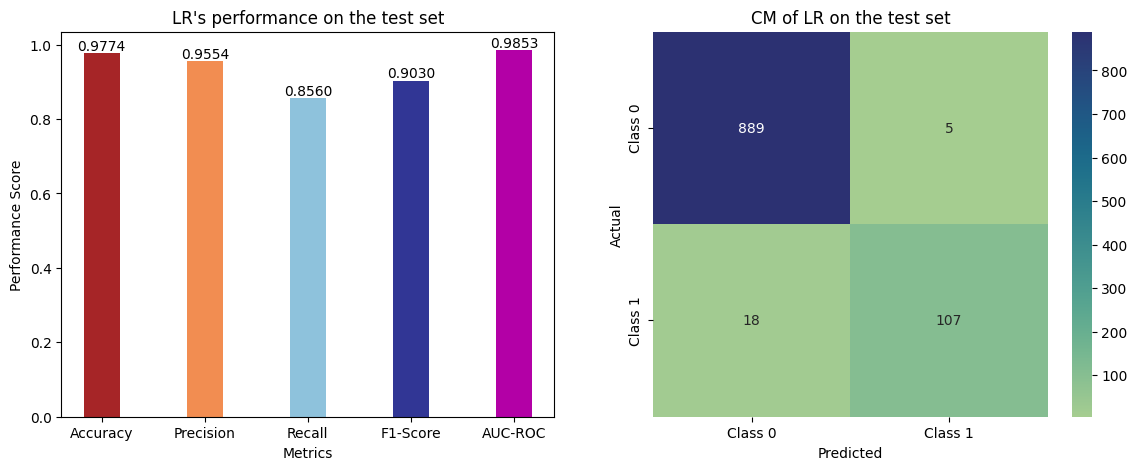

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, svc_2.predict(X_test)),
                                precision_score(y_test, svc_2.predict(X_test)),
                                recall_score(y_test, svc_2.predict(X_test)),
                                f1_score(y_test, svc_2.predict(X_test)),
                                roc_auc_score(svc_2, X_test, y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix(model=svc_2, X=X_test, y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1])

### 2.3.3. Cross validation

In [84]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a logistic regression model
svc_3 = SVC(class_weight='balanced', probability=True)

X_train_arr = X_train.toarray()

# Variables to store overall performance metrics
total_accuracy_train = 0
total_accuracy_test = 0

# Metrics history
fold_numbers = list(range(1, 11))
training_accuracy_history = []
test_accuracy_history = []
training_precision_history = []
test_precision_history = []
training_recall_history = []
test_recall_history = []
training_f1score_history = []
test_f1score_history = []
i = 0

# Perform KFold cross-validation
for train_index, test_index in skf.split(X_train_arr, y_train):
    X_train_f, X_test_f = X_train_arr[train_index], X_train_arr[test_index]
    y_train_f, y_test_f = y_train.iloc[train_index], y_train.iloc[test_index]  # Sử dụng iloc để lấy dữ liệu từ DataFrame

    # Train the model
    svc_3.fit(X_train_f, y_train_f)

    # Make predictions
    y_train_pred = svc_3.predict(X_train_f)
    y_test_pred = svc_3.predict(X_test_f)

    # Log all values for model evaluation
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    precision_train = precision_score(y_train_f, y_train_pred)
    precision_test = precision_score(y_test_f, y_test_pred)
    recall_train = recall_score(y_train_f, y_train_pred)
    recall_test = recall_score(y_test_f, y_test_pred)
    f1_train = f1_score(y_train_f, y_train_pred)
    f1_test = f1_score(y_test_f, y_test_pred)

    # Append values to the history lists
    training_accuracy_history.append(accuracy_train)
    test_accuracy_history.append(accuracy_test)
    training_precision_history.append(precision_train)
    test_precision_history.append(precision_test)
    training_recall_history.append(recall_train)
    test_recall_history.append(recall_test)
    training_f1score_history.append(f1_train)
    test_f1score_history.append(f1_test)

    # Evaluate the model
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    total_accuracy_train += accuracy_train
    total_accuracy_test += accuracy_test

    # Print classification report and confusion matrix for each fold
    print(f'\nFold {i + 1}:')
    print(f'Accuracy (Train): {accuracy_train}')
    print('Classification Report (Train):')
    print(classification_report(y_train_f, y_train_pred))

    print('Confusion Matrix (Train):')
    print(confusion_matrix(y_train_f, y_train_pred))

    print(f'Accuracy (Test): {accuracy_test}')
    print('Classification Report (Test):')
    print(classification_report(y_test_f, y_test_pred))

    print('Confusion Matrix (Test):')
    print(confusion_matrix(y_test_f, y_test_pred))

    i+=1

# Calculate the average accuracy over all folds
average_accuracy_train = total_accuracy_train / n_splits
average_accuracy_test = total_accuracy_test / n_splits

print(f'Average Training Accuracy: {average_accuracy_train}')
print(f'Average Testing Accuracy: {average_accuracy_test}')


Fold 1:
Accuracy (Train): 0.9996591683708248
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2574
           1       1.00      1.00      1.00       360

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Confusion Matrix (Train):
[[2573    1]
 [   0  360]]
Accuracy (Test): 0.9693251533742331
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       287
           1       0.97      0.77      0.86        39

    accuracy                           0.97       326
   macro avg       0.97      0.88      0.92       326
weighted avg       0.97      0.97      0.97       326

Confusion Matrix (Test):
[[286   1]
 [  9  30]]

Fold 2:
Accuracy (Train): 0.9993183367416496
Classification Report (Train):
              precision  

In [85]:
evaluation(svc_3, X_train.toarray(), y_train, 'Classification report on training set:', metric=classification_report)
print()
evaluation(svc_3, X_test.toarray(), y_test, 'Classification report on test set:', metric=classification_report)

Classification report on training set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2861
           1       1.00      0.97      0.99       399

    accuracy                           1.00      3260
   macro avg       1.00      0.99      0.99      3260
weighted avg       1.00      1.00      1.00      3260


Classification report on test set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       894
           1       0.98      0.79      0.88       125

    accuracy                           0.97      1019
   macro avg       0.98      0.89      0.93      1019
weighted avg       0.97      0.97      0.97      1019



In [86]:
overall_evaluation(svc_3, X_test.toarray(), y_test)

Accuracy: 0.9725
Precision: 0.9802
Recall: 0.792
F1-score: 0.8761


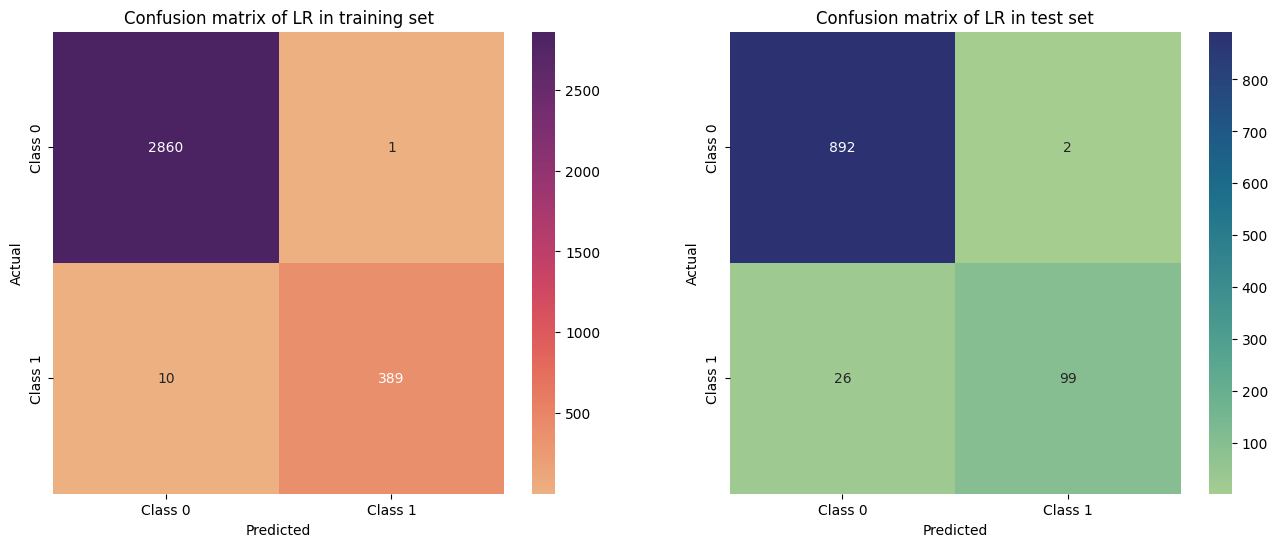

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=svc_3, X=X_train.toarray(), y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=svc_3, X=X_test.toarray(), y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

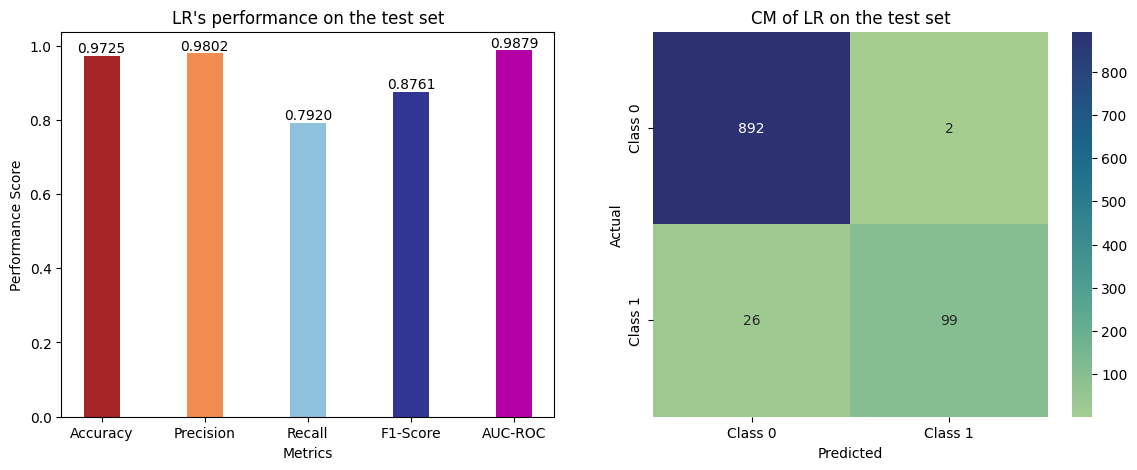

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, svc_3.predict(X_test.toarray())),
                                precision_score(y_test, svc_3.predict(X_test.toarray())),
                                recall_score(y_test, svc_3.predict(X_test.toarray())),
                                f1_score(y_test, svc_3.predict(X_test.toarray())),
                                roc_auc_score(svc_3, X_test.toarray(), y_test),
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix(model=svc_3, X=X_test.toarray(), y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1])

### 2.2.4. Cross validation with hyperparameters tuning

In [90]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a logistic regression model
svc_4 = SVC(C=1, class_weight='balanced', gamma='scale', kernel='sigmoid', probability=True)

X_train_arr = X_train.toarray()

# Variables to store overall performance metrics
total_accuracy_train = 0
total_accuracy_test = 0

# Metrics history
fold_numbers = list(range(1, 11))
training_accuracy_history = []
test_accuracy_history = []
training_precision_history = []
test_precision_history = []
training_recall_history = []
test_recall_history = []
training_f1score_history = []
test_f1score_history = []
i = 0

# Perform KFold cross-validation
for train_index, test_index in skf.split(X_train_arr, y_train):
    X_train_f, X_test_f = X_train_arr[train_index], X_train_arr[test_index]
    y_train_f, y_test_f = y_train.iloc[train_index], y_train.iloc[test_index]  # Sử dụng iloc để lấy dữ liệu từ DataFrame

    # Train the model
    svc_4.fit(X_train_f, y_train_f)

    # Make predictions
    y_train_pred = svc_4.predict(X_train_f)
    y_test_pred = svc_4.predict(X_test_f)

    # Log all values for model evaluation
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    precision_train = precision_score(y_train_f, y_train_pred)
    precision_test = precision_score(y_test_f, y_test_pred)
    recall_train = recall_score(y_train_f, y_train_pred)
    recall_test = recall_score(y_test_f, y_test_pred)
    f1_train = f1_score(y_train_f, y_train_pred)
    f1_test = f1_score(y_test_f, y_test_pred)

    # Append values to the history lists
    training_accuracy_history.append(accuracy_train)
    test_accuracy_history.append(accuracy_test)
    training_precision_history.append(precision_train)
    test_precision_history.append(precision_test)
    training_recall_history.append(recall_train)
    test_recall_history.append(recall_test)
    training_f1score_history.append(f1_train)
    test_f1score_history.append(f1_test)

    # Evaluate the model
    accuracy_train = accuracy_score(y_train_f, y_train_pred)
    accuracy_test = accuracy_score(y_test_f, y_test_pred)
    total_accuracy_train += accuracy_train
    total_accuracy_test += accuracy_test

    # Print classification report and confusion matrix for each fold
    print(f'\nFold {i + 1}:')
    print(f'Accuracy (Train): {accuracy_train}')
    print('Classification Report (Train):')
    print(classification_report(y_train_f, y_train_pred))

    print('Confusion Matrix (Train):')
    print(confusion_matrix(y_train_f, y_train_pred))

    print(f'Accuracy (Test): {accuracy_test}')
    print('Classification Report (Test):')
    print(classification_report(y_test_f, y_test_pred))

    print('Confusion Matrix (Test):')
    print(confusion_matrix(y_test_f, y_test_pred))

    i+=1

# Calculate the average accuracy over all folds
average_accuracy_train = total_accuracy_train / n_splits
average_accuracy_test = total_accuracy_test / n_splits

print(f'Average Training Accuracy: {average_accuracy_train}')
print(f'Average Testing Accuracy: {average_accuracy_test}')


Fold 1:
Accuracy (Train): 0.9914792092706203
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2574
           1       0.94      0.99      0.97       360

    accuracy                           0.99      2934
   macro avg       0.97      0.99      0.98      2934
weighted avg       0.99      0.99      0.99      2934

Confusion Matrix (Train):
[[2551   23]
 [   2  358]]
Accuracy (Test): 0.9693251533742331
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       287
           1       0.91      0.82      0.86        39

    accuracy                           0.97       326
   macro avg       0.95      0.91      0.92       326
weighted avg       0.97      0.97      0.97       326

Confusion Matrix (Test):
[[284   3]
 [  7  32]]

Fold 2:
Accuracy (Train): 0.9925017041581459
Classification Report (Train):
              precision  

In [91]:
evaluation(svc_4, X_train.toarray(), y_train, 'Classification report on training set:', metric=classification_report)
print()
evaluation(svc_4, X_test.toarray(), y_test, 'Classification report on test set:', metric=classification_report)

Classification report on training set:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2861
           1       0.94      0.99      0.96       399

    accuracy                           0.99      3260
   macro avg       0.97      0.99      0.98      3260
weighted avg       0.99      0.99      0.99      3260


Classification report on test set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       894
           1       0.91      0.86      0.89       125

    accuracy                           0.97      1019
   macro avg       0.94      0.93      0.93      1019
weighted avg       0.97      0.97      0.97      1019



In [92]:
overall_evaluation(svc_4, X_test.toarray(), y_test)

Accuracy: 0.9725
Precision: 0.9076
Recall: 0.864
F1-score: 0.8852


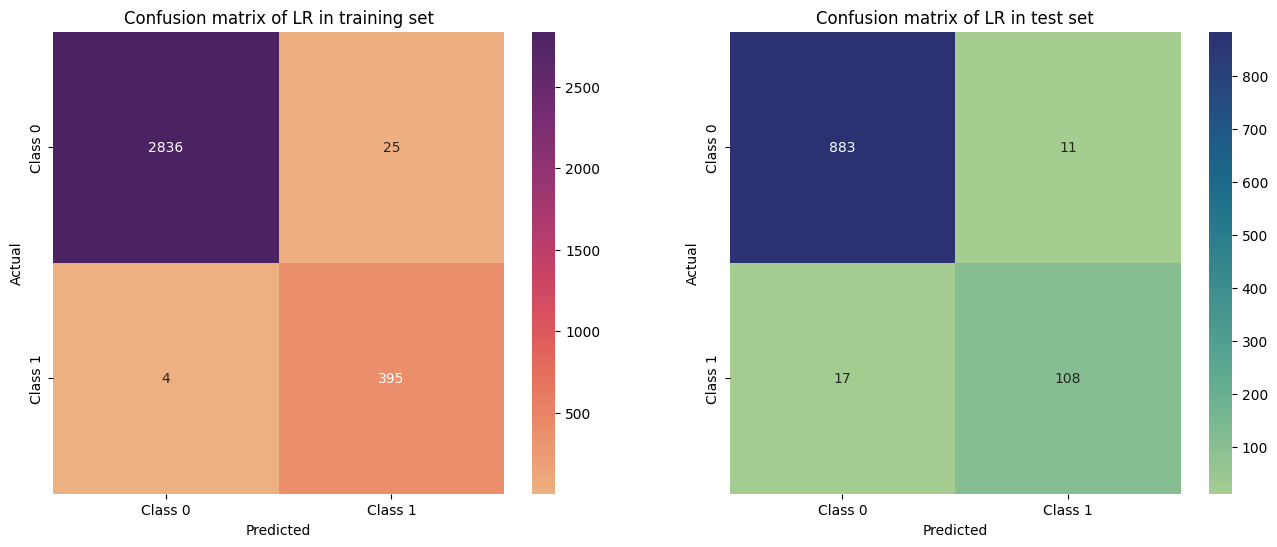

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
visualize_confusion_matrix(model=svc_4, X=X_train.toarray(), y=y_train, cmap='flare', title='Confusion matrix of LR in training set', ax=axs[0])
visualize_confusion_matrix(model=svc_4, X=X_test.toarray(), y=y_test, cmap='crest', title='Confusion matrix of LR in test set', ax=axs[1])

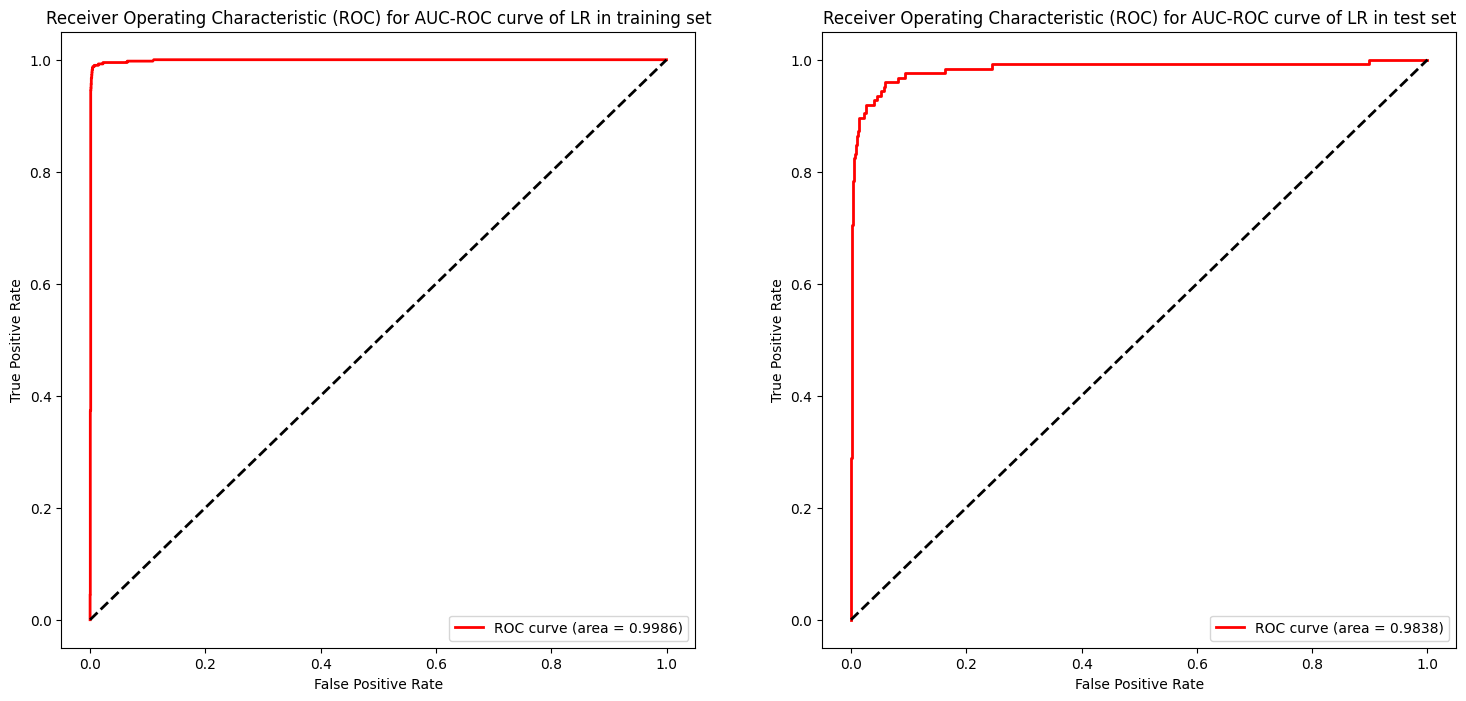

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_auc_roc_curve(model=svc_4, X_test=X_train.toarray(), y_test=y_train, model_name='AUC-ROC curve of LR in training set', ax=ax[0])
visualize_auc_roc_curve(model=svc_4, X_test=X_test.toarray(), y_test=y_test, model_name='AUC-ROC curve of LR in test set', ax=ax[1])

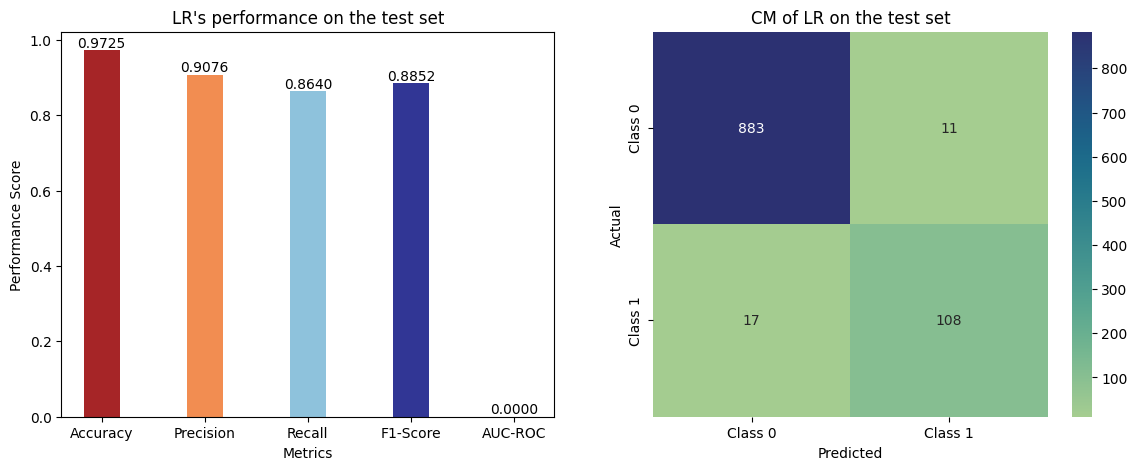

In [311]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
visualize_metrics_into_barchart(accuracy_score(y_test, svc_4.predict(X_test.toarray())),
                                precision_score(y_test, svc_4.predict(X_test.toarray())),
                                recall_score(y_test, svc_4.predict(X_test.toarray())),
                                f1_score(y_test, svc_4.predict(X_test.toarray())),
                                0,
                                model_name='LR',
                                ax=axs[0])
visualize_confusion_matrix(model=svc_4, X=X_test.toarray(), y=y_test, cmap='crest', title='CM of LR on the test set', ax=axs[1])

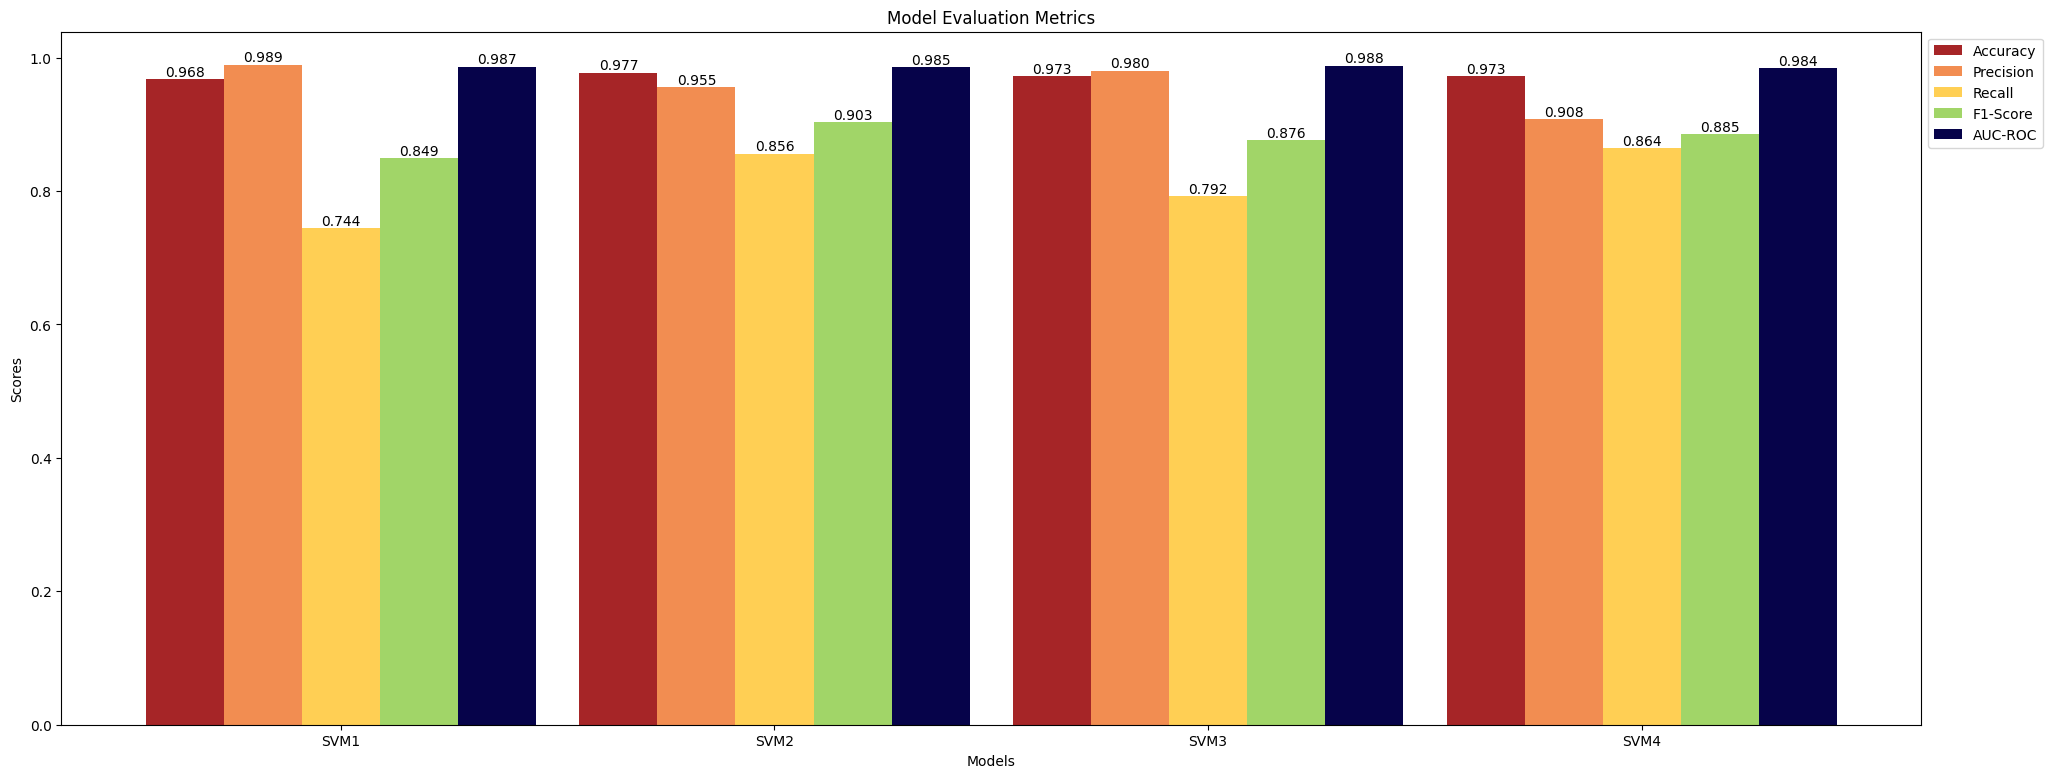

In [2]:
categories = ['SVM1', 'SVM2', 'SVM3', 'SVM4']
accuracies = [0.9676, 0.9774, 0.9725, 0.9725]
precisions = [0.9894, 0.9554, 0.9802, 0.9076]
recalls = [0.744, 0.856, 0.792, 0.864]
f1scores = [0.8493, 0.903, 0.8761, 0.8852]
auc_rocs = [0.9867, 0.9853, 0.9879, 0.9838]

bar_width = 0.18
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(24, 9))

bar1 = ax.bar(index - 2*bar_width, accuracies, bar_width, label='Accuracy', color='#A62527')
bar2 = ax.bar(index - bar_width, precisions, bar_width, label='Precision', color='#F28D51')
bar3 = ax.bar(index, recalls, bar_width, label='Recall', color='#FFCF54')
bar4 = ax.bar(index + bar_width, f1scores, bar_width, label='F1-Score', color='#A1D568')
bar5 = ax.bar(index + 2*bar_width, auc_rocs, bar_width, label='AUC-ROC', color='#06034A')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend(bbox_to_anchor=(1, 1))

# Thêm giá trị trên đỉnh của các cột
for bars in [bar1, bar2, bar3, bar4, bar5]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom'
        )

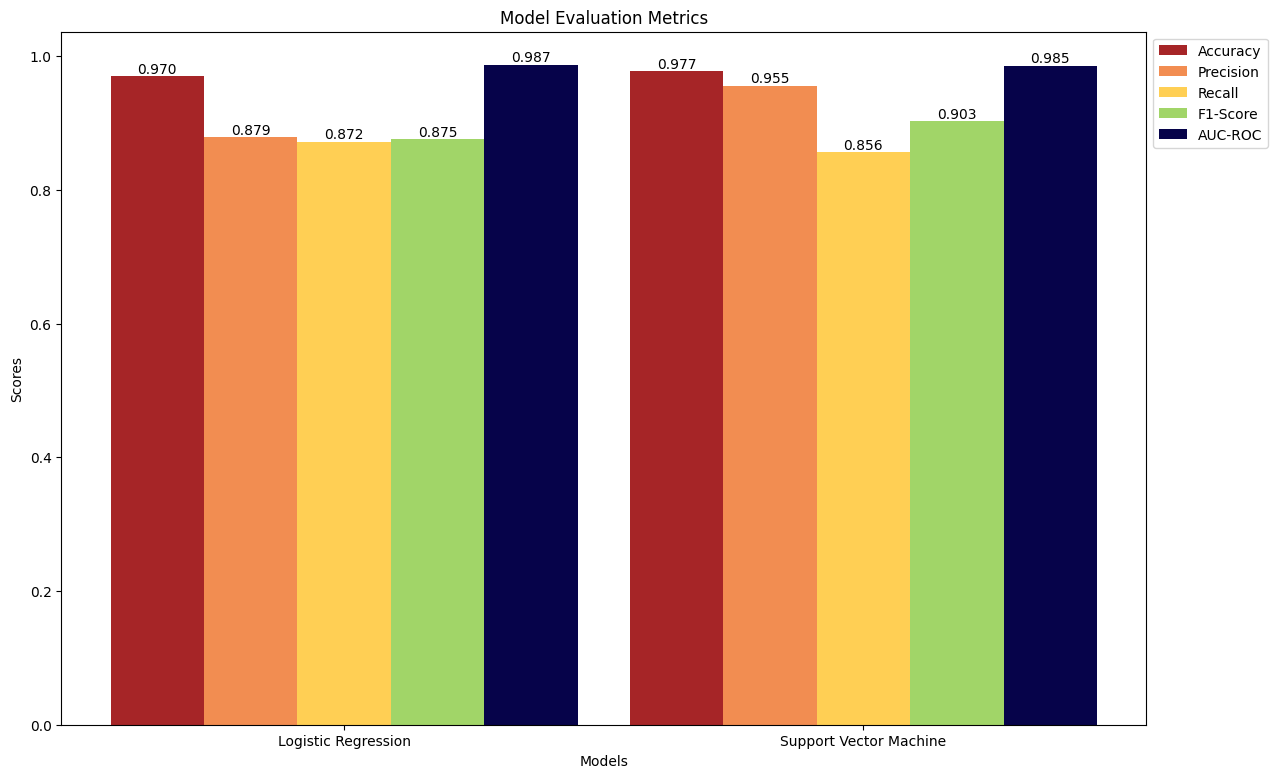

In [4]:
categories = ['Logistic Regression', 'Support Vector Machine']
accuracies = [0.9696, 0.9774]
precisions = [0.879, 0.9554]
recalls = [0.872, 0.856]
f1scores = [0.8755, 0.903]
auc_rocs = [0.987, 0.9853]

bar_width = 0.18
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(14, 9))

bar1 = ax.bar(index - 2*bar_width, accuracies, bar_width, label='Accuracy', color='#A62527')
bar2 = ax.bar(index - bar_width, precisions, bar_width, label='Precision', color='#F28D51')
bar3 = ax.bar(index, recalls, bar_width, label='Recall', color='#FFCF54')
bar4 = ax.bar(index + bar_width, f1scores, bar_width, label='F1-Score', color='#A1D568')
bar5 = ax.bar(index + 2*bar_width, auc_rocs, bar_width, label='AUC-ROC', color='#06034A')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend(bbox_to_anchor=(1, 1))

# Thêm giá trị trên đỉnh của các cột
for bars in [bar1, bar2, bar3, bar4, bar5]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom'
        )

In [98]:
import pickle

In [99]:
pickle.dump(tfidf, open('./MODELS/vectorizer.pkl', 'wb'))
pickle.dump(log_reg_4, open('./MODELS/LogisticRegression.pkl', 'wb'))
pickle.dump(svc_2, open('./MODELS/SupportVectorClassifier.pkl', 'wb'))